# Plot velocities for each experiment

Ran the model using  MOM branch `dev/gfdl-oct7_2025+PGISfixes`: https://github.com/claireyung/MOM6/releases/tag/CYPGv2

Starting from NOAA-GFDL commit:

```
commit 4622d6a0f9fb6f09ba859387a176ff5320054cee (origin/dev/gfdl, origin/HEAD, dev/gfdl-oct7_2025)
Author: Robert Hallberg <Robert.Hallberg@noaa.gov>
Date:   Wed Oct 1 10:48:32 2025 -0400

    +*Fix 3-equation ice-ocean flux iteration (#972)
    
```

Plus cherry picked additional commits to 
1. add hack mode for perfect sigma initialisation
2. add diagnostics for reference interface in PG algorithm
3. Bugfix for melt rate on, velocity sampling distance

```
git cherry-pick 06e8279cf2d0a673da063b8802ecf32e8e7a389e
git cherry-pick d632b4cec6fc501b3fdb546453676014e1149aa0
git cherry-pick a25b1a8586f74776e45cf5628feaf830118f8068
```

To run the model experiments (except ISOMIP ones), you can use `bash run_all.sh`

For ISOMIP models, `cd` into each folder (`MOM6-examples-z`,`MOM6-examples-z-noMWIPG`,`z-ISOMIP-quiet`) and use `mpirun  -host localhost ../../../../build/ocean_only/MOM6 -n 8`(these are slower because they are 3D - take a while on my PC!)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import netCDF4 as nc
import cmocean as cm

from xgcm import Grid

### Define some useful functions/plotting routines

In [2]:
basee = '/Users/claireyung/mom6/MOM6-examples/ocean_only/ISOMIP/seamount-icemount-PGtest-sep25/'
def open_files(label):
    base = basee 
    prog = xr.open_dataset(base + label+'/prog.nc')
    return prog
def open_mom(label):
    base = basee 
    mom = xr.open_dataset(base + label+'/mommean.nc')
    return mom
def open_IC(label):
    base = basee 
    IC = xr.open_dataset(base + label+'/MOM_IC.nc')
    return IC
def plot(ax,yy0,tt,variable,varname,vmin1,vmax1,cmap,ymax):
    prog = open_files(label)
    ocean_static = xr.open_dataset(label +'/ocean_geometry.nc')
    grid = Grid(prog,coords={"x":{"center":"xh","outer":"xq"},
                             "y":{"center":"yh","outer":"yq"},
                             "z":{"center":"zl","outer":"zi"}},periodic=False)
    file_name = label
    #IC = open_IC(label)
    depth = grid.interp(prog.e,"x")
    lon = ocean_static.geolonb
    dataplot = variable

    xx = lon
    if (varname == "uo") or (varname == "PFu") or (varname == "visc_rem_u"): 
        dataplot = grid.interp(dataplot,"x")
    levels = np.linspace(vmin1, vmax1, 51)
    yy = depth[:,:,yy0,:]
    z_levels = yy.shape[1]
    yi = np.linspace(0,5000,z_levels) 
    xi, yyi = np.meshgrid(xx[yy0,:], yi) 
    #print(xi.shape)
    #print(yy[tt,...].shape)
    #print(dataplot[tt,:,yy0,:].shape)
    cax = ax.pcolormesh(xi,yy[tt,...],dataplot[tt,:,yy0,:],vmin = vmin1, vmax = vmax1, cmap = cmap)
    if (varname == "uo"):
        cbar = plt.colorbar(cax, ax = ax, label = " ")
        cbar.formatter.set_powerlimits((0, 0))
        cbar.formatter.set_useMathText(True)
        cbar.ax.yaxis.set_offset_position('right')
        cbar.update_ticks()

    else:
        plt.colorbar(cax, ax = ax, label = varname)
    #plt.colorbar(cax, ax = ax, label = 'u (m/s)')
    
    ## plot interface heights
    i_heights = prog.e # this is 'Interface Height Relative to Mean Sea Level'
    # do for one time
    i_heights = i_heights.isel(Time = tt)
    # take zonal mean
    i_heights = i_heights.isel(yh = yy0)#.mean('xh')

    # plot a line of layer depths, layer by layer
    nz = len(i_heights.zi)
    xh = prog.xh

    for i in range(nz):
        ax.plot(xh,i_heights[i], color = 'k', linewidth = 0.5)
    
    ax.set_ylim(ymin=-ymax,ymax=0)
    ax.set_ylabel('Depth (m)')
    ax.set_xlabel('x (km)')
    ax.set_title(varname+' , ' +label)
    


In [8]:
def plot_u(ax,yy0,tt,variable,varname,vmin1,vmax1,cmap,ymax,ymin = 20, magic = True): #boudnaries are t cell grid
    prog = open_files(label)
    ocean_static = xr.open_dataset(label +'/ocean_geometry.nc')
    grid = Grid(prog,coords={"x":{"center":"xh","outer":"xq"},
                             "y":{"center":"yh","outer":"yq"},
                             "z":{"center":"zl","outer":"zi"}},periodic=False)
    file_name = label
    #IC = open_IC(label)
    depth = prog.e#grid.interp(prog.e,"x")
    lon = prog.e*0 + prog.xh
    dataplot = variable[:,:,:,1:-1]

    #xx = lon
    #if (varname == "uo") or (varname == "PFu") or (varname == "visc_rem_u"): 
    #    dataplot = grid.interp(dataplot,"x")
    levels = np.linspace(vmin1, vmax1, 51)
    #yy = depth[:,:,yy0,:]
    #z_levels = yy.shape[1]
    #yi = np.linspace(0,5000,z_levels) 
    #xi, yyi = np.meshgrid(xx[yy0,:], y) 
    #print(xi.shape)
    #print(yy[tt,...].shape)
    #print(dataplot[tt,:,yy0,:].shape)
    #cax = ax.pcolormesh(xi,yy[tt,...],dataplot[tt,:,yy0,:],vmin = vmin1, vmax = vmax1, cmap = cmap)
#     print(lon.shape)
#     print(depth.shape)
#     print(dataplot.shape)
    cax = ax.pcolormesh(lon[tt,:,yy0,...],depth[tt,:,yy0,...],dataplot[tt,:,yy0,:],vmin = vmin1, vmax = vmax1, cmap = cmap)
    if (varname == "uo"):
        cbar = plt.colorbar(cax, ax = ax, label = " ")
        cbar.formatter.set_powerlimits((0, 0))
        cbar.formatter.set_useMathText(True)
        cbar.ax.yaxis.set_offset_position('right')
        cbar.update_ticks()

    else:
        plt.colorbar(cax, ax = ax, label = varname)
    #plt.colorbar(cax, ax = ax, label = 'u (m/s)')
    
    ## plot interface heights
    i_heights = prog.e # this is 'Interface Height Relative to Mean Sea Level'
    # do for one time
    i_heights = i_heights.isel(Time = tt)
    # take zonal mean
    i_heights = i_heights.isel(yh = yy0)#.mean('xh')

    # plot a line of layer depths, layer by layer
    nz = len(i_heights.zi)
    xh = prog.xh

    for i in range(nz):
        ax.plot(xh,i_heights[i], color = 'k', linewidth = 0.5)
    if magic == True:
        try:
            mom = open_mom(label)
            reset_ht = mom.reset_u.isel(Time = 0).isel(yh = yy0)
            height_reset = np.zeros(len(reset_ht.xq))
            for x in np.arange(1,len(reset_ht.xq)-1):
                # find depth
                if (np.max(reset_ht.isel(xq = x).values)==0):
                    idx = -1 # using surface
                elif (np.max(reset_ht.isel(xq = x).values)==2):
                    idx = -1 # using surface
                else:
                    idx = np.argmax(reset_ht.isel(xq = x).values)
                    print(idx)
                height_reset[x] = grid.interp(prog.e,"x").isel(Time = 0).isel(yh = yy0).isel(xq = x)[idx+1]

            ax.plot(prog.xq[1:-1], height_reset[1:-1], alpha = 0.5, color = 'yellow', linewidth = 2, zorder = 10)
        except AttributeError:
            print('No magic interface output')

    
    ax.set_ylim(ymin=-ymax,ymax=ymin)
    ax.set_ylabel('Depth (m)')
    ax.set_xlabel('x (km)')
    ax.set_title(varname+' , ' +label)
    


### An example testing the magic interface code

/var/folders/dq/psqyj9ns2m9b5kxdvtqz90bm0000gp/T/ipykernel_39047/3058611483.py:8: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates prior reform date (1582-10-15). To silence this warning specify 'use_cftime=True'.
  mom = xr.open_dataset(base + label+'/mommean.nc')
/var/folders/dq/psqyj9ns2m9b5kxdvtqz90bm0000gp/T/ipykernel_39047/3058611483.py:8: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  mom = xr.open_dataset(base + label+'/mommean.nc')
/Users/claireyung/opt/anaconda3/envs/analysis-local/lib/python3.13/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimensi

2


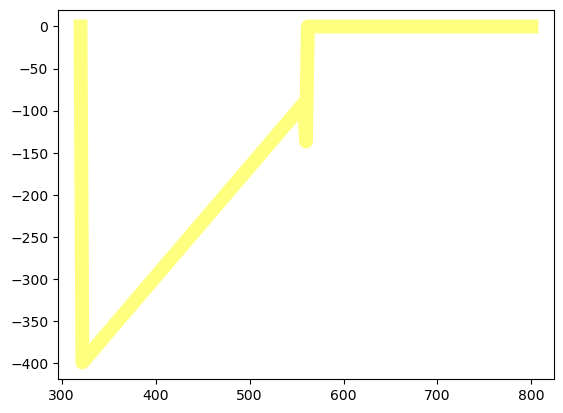

In [9]:
label = 'iceshelf2-sigma'
prog = open_files(label)
fig,ax = plt.subplots()
#try:
mom = open_mom(label)
yy0 = 0
grid = Grid(prog,coords={"x":{"center":"xh","outer":"xq"},
                         "y":{"center":"yh","outer":"yq"},
                         "z":{"center":"zl","outer":"zi"}},periodic=False)

depth = grid.interp(prog.e,"x")
reset_ht = mom.reset_u.isel(Time = -1).isel(yh = yy0)

height_reset = np.zeros(len(reset_ht.xq))
for x in np.arange(1,len(reset_ht.xq)-1):
    # find depth
    if (np.max(reset_ht.isel(xq = x).values)==0):
        idx = -1
    elif (np.max(reset_ht.isel(xq = x).values)==2):
        idx = -1 # using surface
    else:
        idx = np.argmax(reset_ht.isel(xq = x).values)
        print(idx)
    height_reset[x] = depth.isel(Time = 0).isel(yh = yy0).isel(xq = x)[idx+1]

ax.plot(prog.xq, height_reset, alpha = 0.5, color = 'yellow', linewidth = 10, zorder = 10)
#except:
#    print('No magic interface output')


In [10]:
def plot_t(ax,yy0,tt,variable,varname,vmin1,vmax1,cmap,ymax): #boundaries are u cell grid https://gist.github.com/adcroft/dde8d3fafd77d0caaa5613e64f1d7eff
    prog = open_files(label)
    ocean_static = xr.open_dataset(label +'/ocean_geometry.nc')
    grid = Grid(prog,coords={"x":{"center":"xh","outer":"xq"},
                             "y":{"center":"yh","outer":"yq"},
                             "z":{"center":"zl","outer":"zi"}},periodic=False)
    file_name = label
    #IC = open_IC(label)
    depth = grid.interp(prog.e,"x", boundary="extend")
    lon = depth*0 + depth.xq
    dataplot = variable

    #xx = lon
    #if (varname == "uo") or (varname == "PFu") or (varname == "visc_rem_u"): 
    #    dataplot = grid.interp(dataplot,"x")
    levels = np.linspace(vmin1, vmax1, 51)
    #yy = depth[:,:,yy0,:]
    #z_levels = yy.shape[1]
    #yi = np.linspace(0,5000,z_levels) 
    #xi, yyi = np.meshgrid(xx[yy0,:], y) 
    #print(xi.shape)
    #print(yy[tt,...].shape)
    #print(dataplot[tt,:,yy0,:].shape)
    #cax = ax.pcolormesh(xi,yy[tt,...],dataplot[tt,:,yy0,:],vmin = vmin1, vmax = vmax1, cmap = cmap)
    #print(lon.shape)
    #print(depth.shape)
    #print(dataplot.shape)
    cax = ax.pcolormesh(lon[tt,:,yy0,...],depth[tt,:,yy0,...],dataplot[tt,:,yy0,:],vmin = vmin1, vmax = vmax1, cmap = cmap)
    if (varname == "uo"):
        cbar = plt.colorbar(cax, ax = ax, label = " ")
        cbar.formatter.set_powerlimits((0, 0))
        cbar.formatter.set_useMathText(True)
        cbar.ax.yaxis.set_offset_position('right')
        cbar.update_ticks()

    else:
        plt.colorbar(cax, ax = ax, label = varname)
    #plt.colorbar(cax, ax = ax, label = 'u (m/s)')
    
    ## plot interface heights
    i_heights = depth # this is 'Interface Height Relative to Mean Sea Level' interpolated to u
    # do for one time
    i_heights = i_heights.isel(Time = tt)
    # take zonal mean
    i_heights = i_heights.isel(yh = yy0)#.mean('xh')

    # plot a line of layer depths, layer by layer
    nz = len(i_heights.zi)
    xq = prog.xq

    for i in range(nz):
        ax.plot(xq,i_heights[i], color = 'k', linewidth = 0.2)
    
    ax.set_ylim(ymin=-ymax,ymax=0)
    ax.set_ylabel('Depth (m)')
    ax.set_xlabel('x (km)')
    ax.set_title(varname+' , ' +label)
    


In [11]:
def plot_u_ISOMIP(ax,yy0,tt,variable,varname,vmin1,vmax1,cmap,ymax,magic = True): #boudnaries are t cell grid
    #prog = prog
    ocean_static = ocean_geometry
    grid = Grid(prog,coords={"x":{"center":"xh","outer":"xq"},
                             "y":{"center":"yh","outer":"yq"},
                             "z":{"center":"zl","outer":"zi"}},periodic=False)
    file_name = label
    #IC = open_IC(label)
    depth = prog.e#grid.interp(prog.e,"x")
    lon = prog.e*0 + prog.xh
    dataplot = variable[:,:,:,1:-1]

    #xx = lon
    #if (varname == "uo") or (varname == "PFu") or (varname == "visc_rem_u"): 
    #    dataplot = grid.interp(dataplot,"x")
    levels = np.linspace(vmin1, vmax1, 51)
    #yy = depth[:,:,yy0,:]
    #z_levels = yy.shape[1]
    #yi = np.linspace(0,5000,z_levels) 
    #xi, yyi = np.meshgrid(xx[yy0,:], y) 
    #print(xi.shape)
    #print(yy[tt,...].shape)
    #print(dataplot[tt,:,yy0,:].shape)
    #cax = ax.pcolormesh(xi,yy[tt,...],dataplot[tt,:,yy0,:],vmin = vmin1, vmax = vmax1, cmap = cmap)
#     print(lon.shape)
#     print(depth.shape)
#     print(dataplot.shape)
    cax = ax.pcolormesh(lon[tt,:,yy0,...],depth[tt,:,yy0,...],dataplot[tt,:,yy0,:],vmin = vmin1, vmax = vmax1, cmap = cmap)
    if (varname == "uo"):
        cbar = plt.colorbar(cax, ax = ax, label = " ")
        cbar.formatter.set_powerlimits((0, 0))
        cbar.formatter.set_useMathText(True)
        cbar.ax.yaxis.set_offset_position('right')
        cbar.update_ticks()

    else:
        plt.colorbar(cax, ax = ax, label = varname)
    #plt.colorbar(cax, ax = ax, label = 'u (m/s)')
    
    ## plot interface heights
    i_heights = prog.e # this is 'Interface Height Relative to Mean Sea Level'
    # do for one time
    i_heights = i_heights.isel(Time = tt)
    # take zonal mean
    i_heights = i_heights.isel(yh = yy0)#.mean('xh')

    # plot a line of layer depths, layer by layer
    nz = len(i_heights.zi)
    xh = prog.xh

    for i in range(nz):
        ax.plot(xh,i_heights[i], color = 'k', linewidth = 0.5)
    if magic == True:
        try:
            reset_ht = mom.reset_u.isel(Time = 0).isel(yh = yy0)
            height_reset = np.zeros(len(reset_ht.xq))
            for x in np.arange(1,len(reset_ht.xq)-1):
                # find depth
                if (np.max(reset_ht.isel(xq = x).values)==0):
                    idx = -1 # using surface
                elif (np.max(reset_ht.isel(xq = x).values)==2):
                    idx = -1 # using surface
                else:
                    idx = np.argmax(reset_ht.isel(xq = x).values)
                    print(idx)
                height_reset[x] = grid.interp(prog.e,"x").isel(Time = 0).isel(yh = yy0).isel(xq = x)[idx+1]

            ax.plot(prog.xq[1:-1], height_reset[1:-1], alpha = 0.5, color = 'yellow', linewidth = 2, zorder = 10)
        except AttributeError:
            print('No magic interface output')
    
    ax.set_ylim(ymin=-ymax,ymax=10)
    ax.set_ylabel('Depth (m)')
    ax.set_xlabel('x (km)')
    ax.set_title(varname+' , ' +label)
    


# Plot model results

/var/folders/dq/psqyj9ns2m9b5kxdvtqz90bm0000gp/T/ipykernel_39047/3058611483.py:8: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates prior reform date (1582-10-15). To silence this warning specify 'use_cftime=True'.
  mom = xr.open_dataset(base + label+'/mommean.nc')
/var/folders/dq/psqyj9ns2m9b5kxdvtqz90bm0000gp/T/ipykernel_39047/3058611483.py:8: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  mom = xr.open_dataset(base + label+'/mommean.nc')
/Users/claireyung/opt/anaconda3/envs/analysis-local/lib/python3.13/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimensi

1
2
4
6
8
9
9
9
8
6
4
2
1


/var/folders/dq/psqyj9ns2m9b5kxdvtqz90bm0000gp/T/ipykernel_39047/3058611483.py:8: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates prior reform date (1582-10-15). To silence this warning specify 'use_cftime=True'.
  mom = xr.open_dataset(base + label+'/mommean.nc')
/var/folders/dq/psqyj9ns2m9b5kxdvtqz90bm0000gp/T/ipykernel_39047/3058611483.py:8: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  mom = xr.open_dataset(base + label+'/mommean.nc')
/Users/claireyung/opt/anaconda3/envs/analysis-local/lib/python3.13/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimensi

1
2
4
6
8
9
9
9
8
6
4
2
1


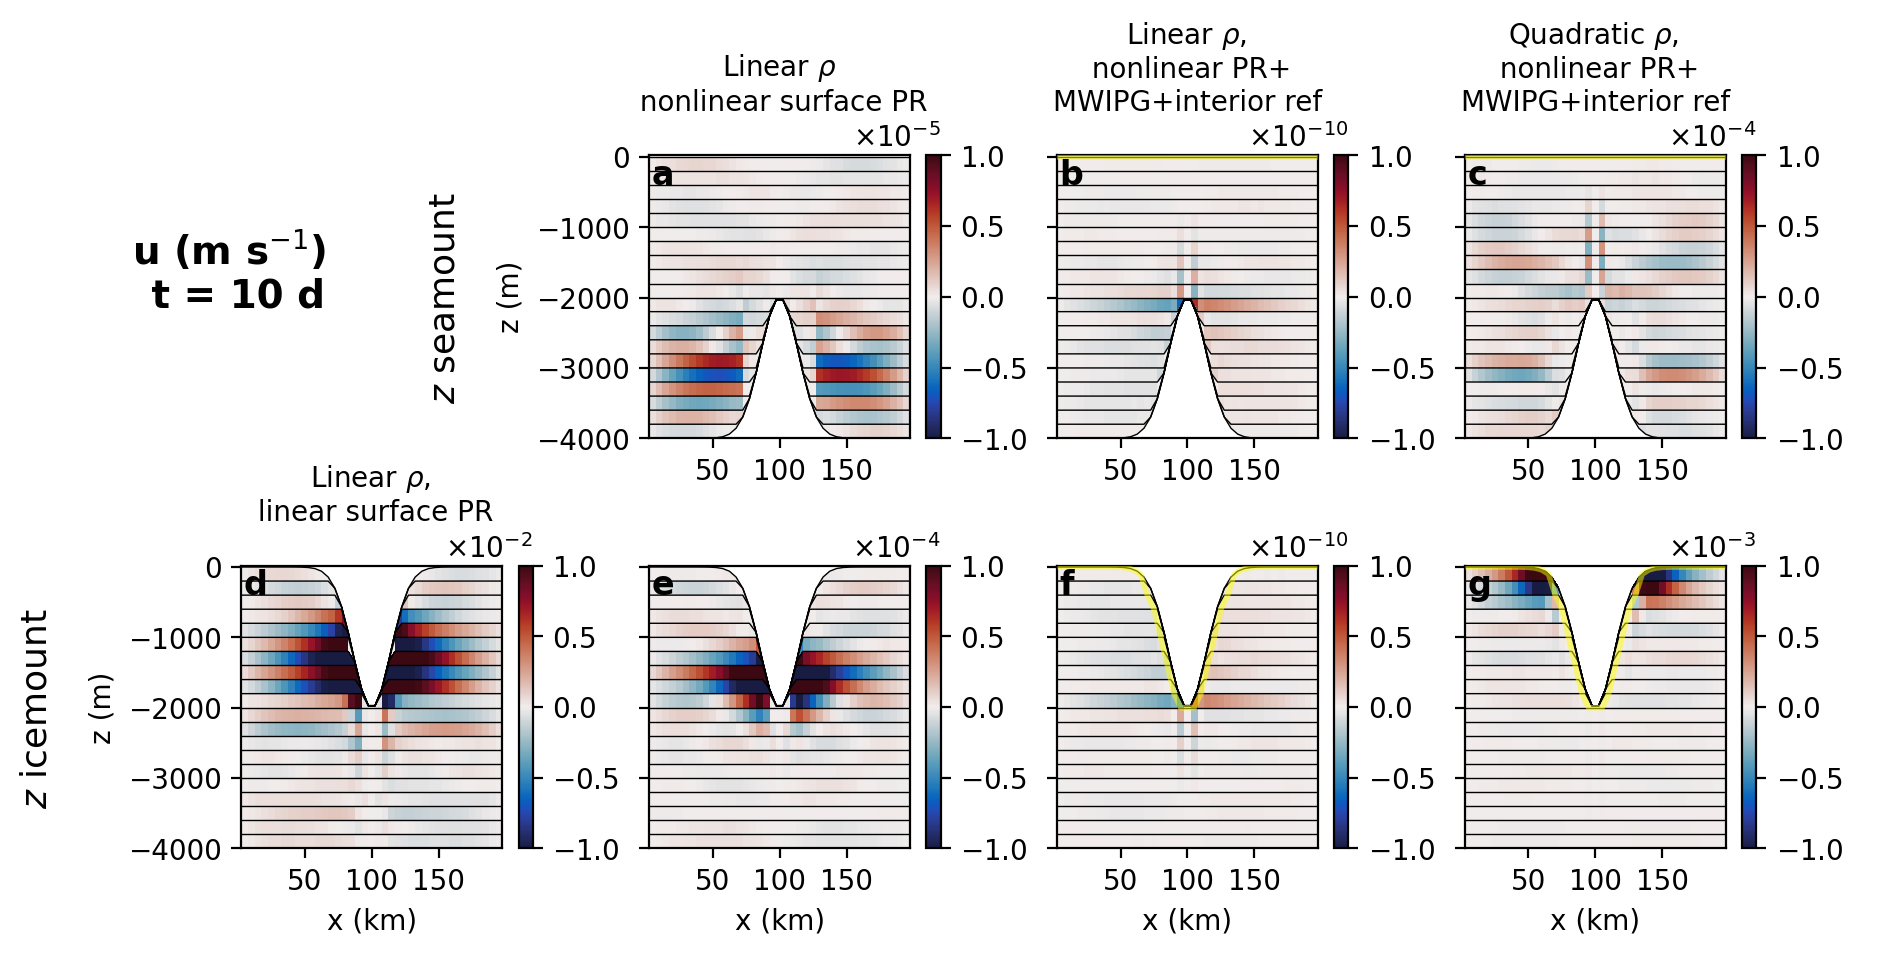

In [12]:
fig, axes = plt.subplots(ncols = 4, nrows = 2, figsize = (10,4.5),dpi = 200)
ax = np.ravel(axes)

for i in np.arange(7):

    label = ['seamount-z','seamount-z-MWIPG','seamount-z-quad-MWIPG',
              'icemount-z-LSPR','icemount-z-surfcorrect','icemount-z-reset','icemount-z-reset-quad'][i]
    loc = i+1
    vmax = [1e-5,1e-10,1e-4,
            1e-2,1e-4,1e-10,1e-3][i]
    magic = [False,True,True,False,False,True,True][i]
    
    a = ax[loc]

    prog = open_files(label)
    x = 0
    ymax = 4000

    plot_u(a,x,-1,prog.u,"uo",-vmax,vmax,cm.cm.balance,ymax, magic=magic)

    a.set_title('')
    if loc < 4:
        a.set_xlabel('')
    if (loc ==1):
        a.set_ylabel('z (m)')
        a.text(-150,-2000,r'$z$ seamount',
               ha = 'center', va = 'center',rotation = 90, fontsize = 13)
    elif (loc==4):
        a.set_ylabel('z (m)')
        a.text(-150,-2000,r'$z$ icemount',
               ha = 'center', va = 'center',rotation = 90, fontsize = 13)
        
    else:
        a.set_ylabel('')
        a.set_yticklabels('')
        
    if loc < 5:
        a.set_title(['',r'Linear $\rho$'+' \n nonlinear surface PR',r'Linear $\rho$, '+'\n nonlinear PR+\nMWIPG+interior ref',r'Quadratic $\rho$, '+'\n nonlinear PR+\nMWIPG+interior ref',r'Linear $\rho$, '+'\n linear surface PR'][loc], 
                    y = 1.1, fontsize = 10)
    a.text(0.01,0.99,['a','b','c','d','e','f','g','h','i','j'][i], fontsize = 12, transform=a.transAxes, fontweight='bold', va='top', zorder = 20)

    
ax[0].set_axis_off()

fig.subplots_adjust(wspace = 0.25,hspace = 0.45)
fig.suptitle('u (m s$^{-1}$)'+' \n t = 10 d', fontsize = 14, y = 0.8, x = 0.12,weight = 'bold')



plt.show()


/var/folders/dq/psqyj9ns2m9b5kxdvtqz90bm0000gp/T/ipykernel_39047/3058611483.py:8: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates prior reform date (1582-10-15). To silence this warning specify 'use_cftime=True'.
  mom = xr.open_dataset(base + label+'/mommean.nc')
/var/folders/dq/psqyj9ns2m9b5kxdvtqz90bm0000gp/T/ipykernel_39047/3058611483.py:8: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  mom = xr.open_dataset(base + label+'/mommean.nc')
/Users/claireyung/opt/anaconda3/envs/analysis-local/lib/python3.13/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimensi

1
2
2
2
2
2
2
2
2
1


/var/folders/dq/psqyj9ns2m9b5kxdvtqz90bm0000gp/T/ipykernel_39047/3058611483.py:8: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates prior reform date (1582-10-15). To silence this warning specify 'use_cftime=True'.
  mom = xr.open_dataset(base + label+'/mommean.nc')
/var/folders/dq/psqyj9ns2m9b5kxdvtqz90bm0000gp/T/ipykernel_39047/3058611483.py:8: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  mom = xr.open_dataset(base + label+'/mommean.nc')
/Users/claireyung/opt/anaconda3/envs/analysis-local/lib/python3.13/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimensi

1
2
2
2
2
2
2
2
2
1


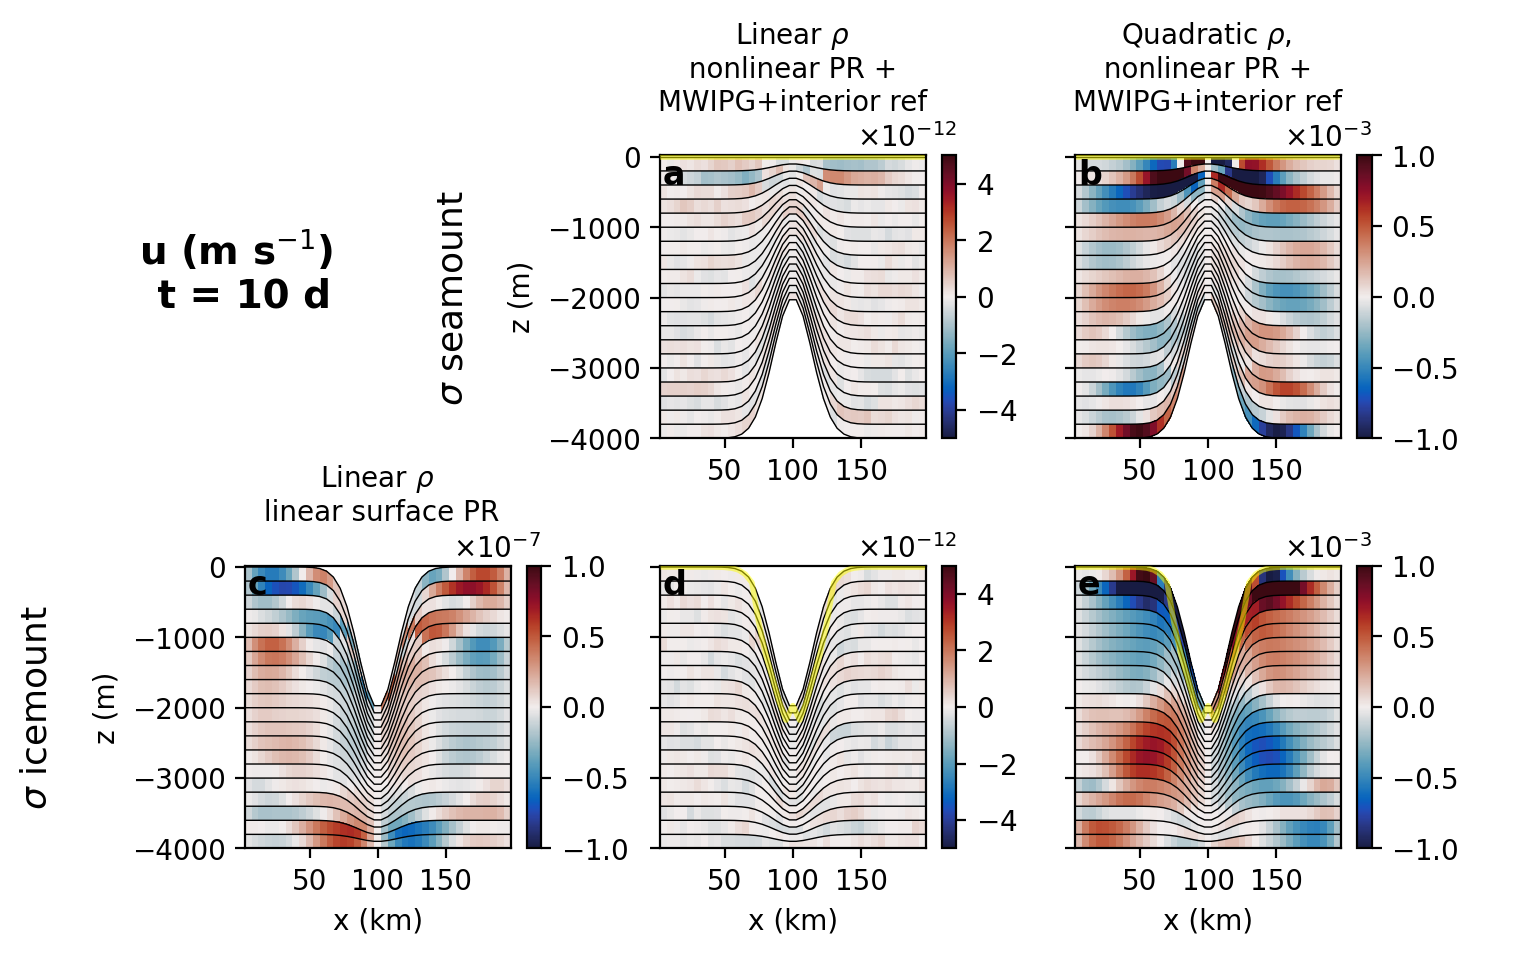

In [13]:
fig, axes = plt.subplots(ncols = 3, nrows = 2, figsize = (7.5,4.5),dpi = 200)
ax = np.ravel(axes)

for i in np.arange(5):

    label = ['seamount-sigma','seamount-sigma-quad',
              'icemount-sigma-LSPR','icemount-sigma-reset','icemount-sigma-reset-quad'][i]
    loc = [1,2,3,4,5][i]
    vmax = [5e-12,1e-3,
            1e-7,5e-12,1e-3][i]
    magic = [True,True,False,True,True][i]
    
    a = ax[loc]

    prog = open_files(label)
    x = 0
    ymax = 4000

    plot_u(a,x,-1,prog.u,"uo",-vmax,vmax,cm.cm.balance,ymax,magic=magic)

    a.set_title('')
    if loc < 3:
        a.set_xlabel('')
    if (loc ==1):
        a.set_ylabel('z (m)')
        a.text(-150,-2000,r'$\sigma$ seamount',
               ha = 'center', va = 'center',rotation = 90, fontsize = 13)
    elif (loc==3):
        a.set_ylabel('z (m)')
        a.text(-150,-2000,r'$\sigma$ icemount',
               ha = 'center', va = 'center',rotation = 90, fontsize = 13)
        
    else:
        a.set_ylabel('')
        a.set_yticklabels('')
        
    if loc < 4:
        a.set_title(['',r'Linear $\rho$'+' \n nonlinear PR + \nMWIPG+interior ref',r'Quadratic $\rho$, '+'\n nonlinear PR + \nMWIPG+interior ref',r'Linear $\rho$'+' \n linear surface PR'][loc], 
                    y = 1.1, fontsize = 10)
    a.text(0.01,0.99,['a','b','c','d','e','f','g','h','i','j'][i], fontsize = 12, transform=a.transAxes, fontweight='bold', va='top', zorder = 20)

    
ax[0].set_axis_off()

fig.subplots_adjust(wspace = 0.25,hspace = 0.45)
fig.suptitle('u (m s$^{-1}$)'+' \n t = 10 d', fontsize = 14, y = 0.8, x = 0.12,weight = 'bold')



plt.show()


/var/folders/dq/psqyj9ns2m9b5kxdvtqz90bm0000gp/T/ipykernel_39047/3058611483.py:8: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates prior reform date (1582-10-15). To silence this warning specify 'use_cftime=True'.
  mom = xr.open_dataset(base + label+'/mommean.nc')
/var/folders/dq/psqyj9ns2m9b5kxdvtqz90bm0000gp/T/ipykernel_39047/3058611483.py:8: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  mom = xr.open_dataset(base + label+'/mommean.nc')
/Users/claireyung/opt/anaconda3/envs/analysis-local/lib/python3.13/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimensi

1
2
4
6
8
9
9
8
6
4
2
1


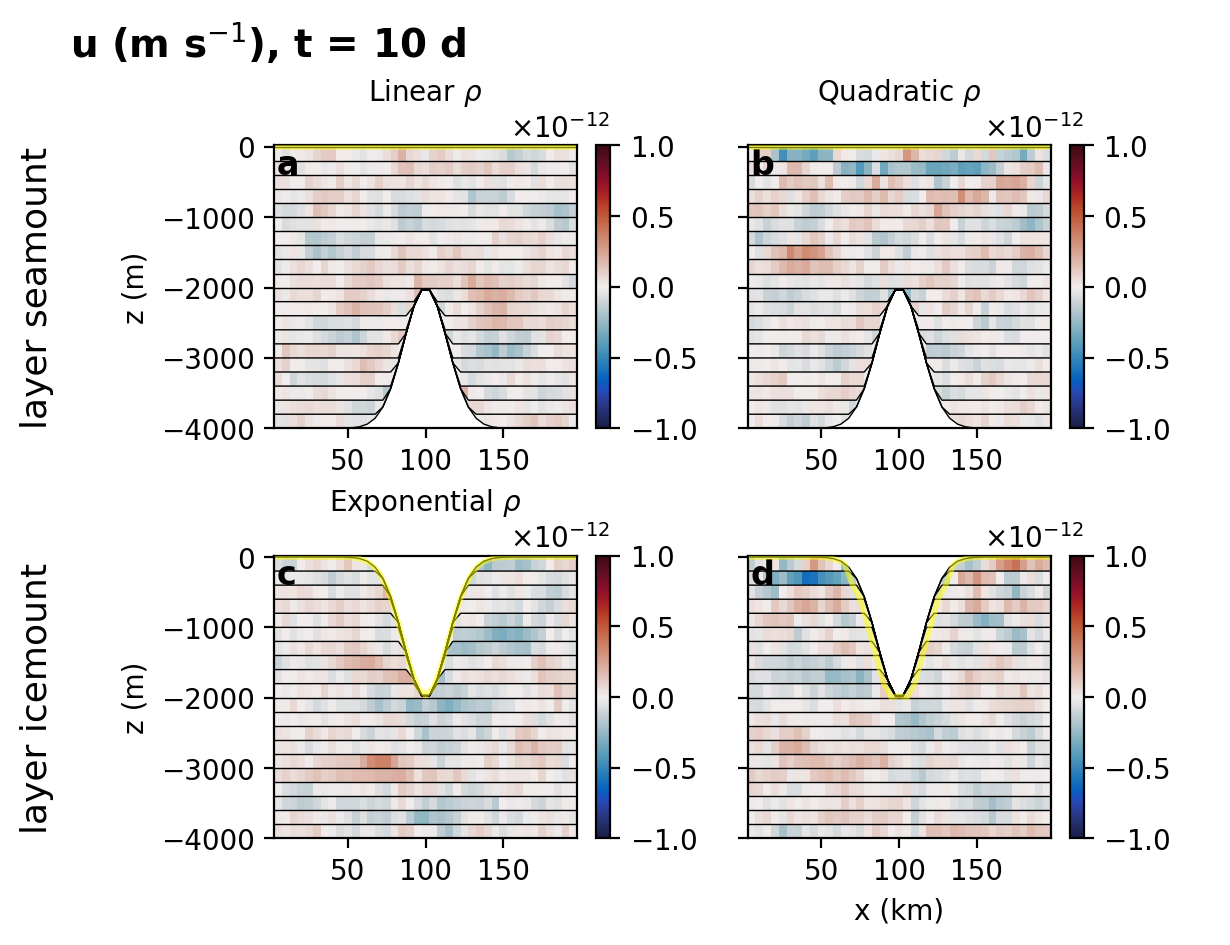

In [14]:
fig, axes = plt.subplots(ncols = 2, nrows = 2, figsize = (5.5,4.5),dpi = 200)
ax = np.ravel(axes)

for i in np.arange(4):

    label = ['seamount-layer','seamount-layer-quad',
              'icemount-layer-LSPR','icemount-layer-reset-quad'][i]
    loc = [0,1,2,3,4,5][i]
    vmax = [1e-12,1e-12,
            1e-12,1e-12,][i]
    
    a = ax[loc]

    prog = open_files(label)
    x = 0
    ymax = 4000

    plot_u(a,x,-1,prog.u,"uo",-vmax,vmax,cm.cm.balance,ymax)

    a.set_title('')
    if loc < 3:
        a.set_xlabel('')
    if (loc ==0):
        a.set_ylabel('z (m)')
        a.text(-150,-2000,r'layer seamount',
               ha = 'center', va = 'center',rotation = 90, fontsize = 13)
    elif (loc==2):
        a.set_ylabel('z (m)')
        a.text(-150,-2000,r'layer icemount',
               ha = 'center', va = 'center',rotation = 90, fontsize = 13)
        
    else:
        a.set_ylabel('')
        a.set_yticklabels('')
        
    if loc < 3:
        a.set_title([r'Linear $\rho$',r'Quadratic $\rho$',r'Exponential $\rho$'][loc], 
                    y = 1.1, fontsize = 10)
    a.text(0.01,0.99,['a','b','c','d','e','f','g','h','i','j'][i], fontsize = 12, transform=a.transAxes, fontweight='bold', va='top')

    
#ax[0].set_axis_off()

fig.subplots_adjust(wspace = 0.25,hspace = 0.45)
fig.suptitle('u (m s$^{-1}$), t = 10 d', fontsize = 14, y = 1.02, x = 0.12,weight = 'bold')



plt.show()


# Plot model results, timeseries of max velocity

<>:58: SyntaxWarning: invalid escape sequence '\s'
<>:58: SyntaxWarning: invalid escape sequence '\s'
<>:75: SyntaxWarning: invalid escape sequence '\s'
<>:58: SyntaxWarning: invalid escape sequence '\s'
<>:58: SyntaxWarning: invalid escape sequence '\s'
<>:75: SyntaxWarning: invalid escape sequence '\s'
/var/folders/dq/psqyj9ns2m9b5kxdvtqz90bm0000gp/T/ipykernel_39047/993733253.py:58: SyntaxWarning: invalid escape sequence '\s'
  '$\sigma$ seamount','$\sigma$ icemount NL PR+\ninterior ref'][i]
/var/folders/dq/psqyj9ns2m9b5kxdvtqz90bm0000gp/T/ipykernel_39047/993733253.py:58: SyntaxWarning: invalid escape sequence '\s'
  '$\sigma$ seamount','$\sigma$ icemount NL PR+\ninterior ref'][i]
/var/folders/dq/psqyj9ns2m9b5kxdvtqz90bm0000gp/T/ipykernel_39047/993733253.py:75: SyntaxWarning: invalid escape sequence '\s'
  axes[1].set_title('Linear Eqn of State \n $\sigma$')


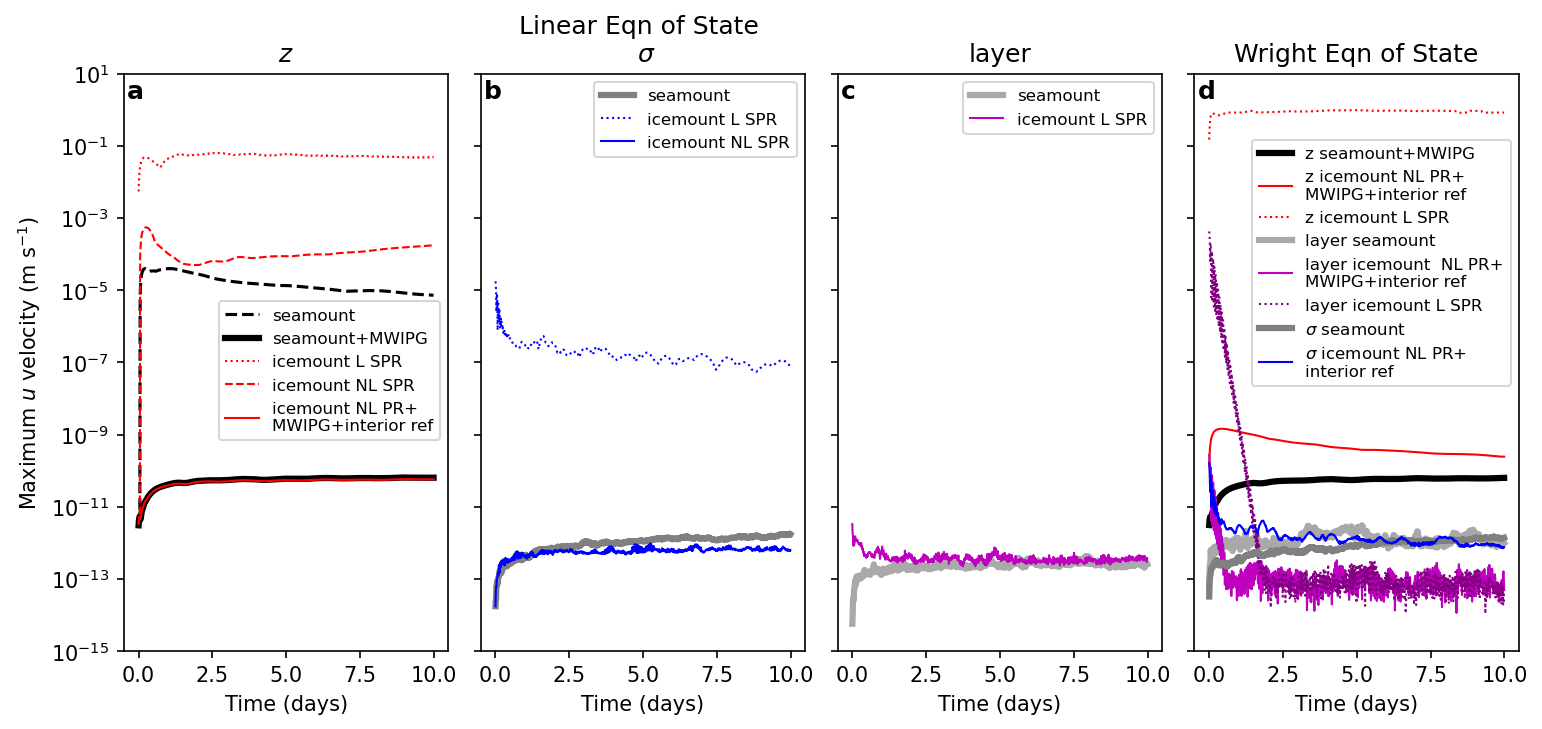

In [15]:
fig, axes = plt.subplots(ncols = 4, figsize = (12,5),dpi = 150, sharey = True)

# for label in ['seamount-layer','seamount-layer-quad','seamount-layer-exp',
#               'icemount-layer-LSPR','icemount-layer-reset-quad','icemount-layer-LSPR-exp',
#               'icemount-layer-reset-exp','icemount-layer-reset-exp-Wright','icemount-layer-reset-Wright',
#              'icemount-layer-LSPR-Wright','seamount-layer-Wright','seamount-layer-quad-Wright',
#              'icemount-z-reset-Wright','icemount-z-LSPR-Wright','seamount-z-MWIPG-Wright','seamount-z-exp-Wright']:
for i in np.arange(5):
    label = ['seamount-z','seamount-z-MWIPG',
              'icemount-z-LSPR','icemount-z-surfcorrect','icemount-z-reset'][i]
    labelplot = ['seamount','seamount+MWIPG','icemount L SPR','icemount NL SPR','icemount NL PR+\nMWIPG+interior ref'][i]
    color = ['k','k','r','r','r'][i]
    linestyle = ['--','-','dotted','--','-'][i]
    linewidth = [1.5,3,1,1,1][i]
    prog = open_files(label)
    axes[0].plot(np.arange(len(prog.Time))/24/4,np.abs(prog.u).max(['zl','yh','xq']), 
                 label = labelplot, color = color, linestyle = linestyle, linewidth = linewidth) 
axes[0].set_ylabel('Maximum $u$ velocity (m s$^{-1}$)')
axes[0].set_xlabel('Time (days)')
axes[0].set_yscale('log')
axes[0].legend(loc = 'upper right', fontsize = 8, bbox_to_anchor = (1,0.62))

for i in np.arange(3):
    label = ['seamount-sigma','icemount-sigma-LSPR','icemount-sigma-reset'][i]
    labelplot = ['seamount','icemount L SPR','icemount NL SPR'][i]
    color = ['gray','b','b','b'][i]
    linestyle = ['-','dotted','-'][i]
    linewidth = [3,1,1,1][i]
    prog = open_files(label)
    axes[1].plot(np.arange(len(prog.Time))/24/4,np.abs(prog.u).max(['zl','yh','xq']), 
                 label = labelplot, color = color, linestyle = linestyle, linewidth = linewidth) 
#axes[0].set_ylabel('Max u vel (m/s)')
axes[1].set_xlabel('Time (days)')
#axes[0].set_yscale('log')
axes[1].legend(loc = 'upper right', fontsize = 8)

for i in np.arange(2):
    label = ['seamount-layer','icemount-layer-LSPR'][i]
    labelplot = ['seamount','icemount L SPR'][i]
    color = ['darkgrey','m','b','b'][i]
    linestyle = ['-','-'][i]
    linewidth = [3,1,1,1][i]
    prog = open_files(label)
    axes[2].plot(np.arange(len(prog.Time))/24/4,np.abs(prog.u).max(['zl','yh','xq']), 
                 label = labelplot, color = color, linestyle = linestyle, linewidth = linewidth) 
#axes[0].set_ylabel('Max u vel (m/s)')
axes[2].set_xlabel('Time (days)')
#axes[0].set_yscale('log')
axes[2].legend(loc = 'upper right', fontsize = 8)


for i in np.arange(8):
    label = ['seamount-z-MWIPG-Wright','icemount-z-reset-Wright','icemount-z-LSPR-Wright',
             'seamount-layer-Wright','icemount-layer-reset-Wright','icemount-layer-LSPR-Wright',
             'seamount-sigma-Wright','icemount-sigma-reset-Wright'][i]
    labelplot = ['z seamount+MWIPG','z icemount NL PR+\nMWIPG+interior ref','z icemount L SPR',
                 'layer seamount', 'layer icemount  NL PR+\nMWIPG+interior ref','layer icemount L SPR',
                 '$\sigma$ seamount','$\sigma$ icemount NL PR+\ninterior ref'][i]
    color = ['k','r','r','darkgrey','m','purple','gray','b',][i]
    linestyle = ['-','-','dotted','-','-','dotted','-','-'][i]
    linewidth = [3,1,1,3,1,1,3,1][i]
    prog = open_files(label)
    axes[3].plot(np.arange(len(prog.Time))/24/4,np.abs(prog.u).max(['zl','yh','xq']), 
                 label = labelplot, color = color, linestyle = linestyle, linewidth = linewidth) 
#axes[0].set_ylabel('Max u vel (m/s)')
axes[3].set_xlabel('Time (days)')
#axes[0].set_yscale('log')
axes[3].legend(loc = 'upper right', bbox_to_anchor = (1,0.9), fontsize = 8)

fig.subplots_adjust(wspace = 0.1)

axes[0].set_ylim(1e-15,10)

axes[0].set_title('$z$')
axes[1].set_title('Linear Eqn of State \n $\sigma$')
axes[2].set_title('layer')
axes[3].set_title('Wright Eqn of State')

# fig.suptitle('Spurious currents in linear temperature and salinity stratification tests', fontweight = 'bold',
#             x = 0.12,ha = 'left', y = 1.06)
for i in np.arange(4):
    axes[i].text(0.01,0.99,['a','b','c','d','e','f','g','h','i','j'][i], fontsize = 12, transform=axes[i].transAxes, fontweight='bold', va='top')


<>:36: SyntaxWarning: invalid escape sequence '\s'
<>:36: SyntaxWarning: invalid escape sequence '\s'
/var/folders/dq/psqyj9ns2m9b5kxdvtqz90bm0000gp/T/ipykernel_39047/3446509230.py:36: SyntaxWarning: invalid escape sequence '\s'
  a.set_title(['$z$','$\sigma$'][loc],
/var/folders/dq/psqyj9ns2m9b5kxdvtqz90bm0000gp/T/ipykernel_39047/3058611483.py:8: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates prior reform date (1582-10-15). To silence this warning specify 'use_cftime=True'.
  mom = xr.open_dataset(base + label+'/mommean.nc')
/var/folders/dq/psqyj9ns2m9b5kxdvtqz90bm0000gp/T/ipykernel_39047/3058611483.py:8: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  mom = xr.open_dataset(base + label+'/mommean.nc')
/Users/claireyung/opt/anaconda3/en

11
11
10
10
10
10
10
10
10
10
10
10
10
10
10
10
9
9
9
9
9
9
9
9
9
9
9
9
9
9
8
8
8
8
8
8
8
8
8
8
8
8
8
8
7
7
7
7
7
7
7
7
7
7
7
7
7
6
6
6
6
6
6
6
6
6
6
6
6
6
6
5
5
5
5
5
5
5
5
5
5
5
5
5
5
4
4
4
4
4
4
4
4
4
4
4
4
4
4
3
3
3
3
3
3
3
3
3
3
3
3
3
2
2
2
2
2
2
2
2


/var/folders/dq/psqyj9ns2m9b5kxdvtqz90bm0000gp/T/ipykernel_39047/3058611483.py:8: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates prior reform date (1582-10-15). To silence this warning specify 'use_cftime=True'.
  mom = xr.open_dataset(base + label+'/mommean.nc')
/var/folders/dq/psqyj9ns2m9b5kxdvtqz90bm0000gp/T/ipykernel_39047/3058611483.py:8: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  mom = xr.open_dataset(base + label+'/mommean.nc')
/Users/claireyung/opt/anaconda3/envs/analysis-local/lib/python3.13/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimensi

2


/var/folders/dq/psqyj9ns2m9b5kxdvtqz90bm0000gp/T/ipykernel_39047/3058611483.py:8: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates prior reform date (1582-10-15). To silence this warning specify 'use_cftime=True'.
  mom = xr.open_dataset(base + label+'/mommean.nc')
/var/folders/dq/psqyj9ns2m9b5kxdvtqz90bm0000gp/T/ipykernel_39047/3058611483.py:8: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  mom = xr.open_dataset(base + label+'/mommean.nc')
/Users/claireyung/opt/anaconda3/envs/analysis-local/lib/python3.13/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimensi

9
9
9
9
9
9
9
9
9
9
9
9
9
8
8
8
8
8
8
8
8
8
8
8
8
8
8
7
7
7
7
7
7
7
7
7
7
7
7
7
6
6
6
6
6
6
6
6
6
6
6
6
6
6
5
5
5
5
5
5
5
5
5
5
5
5
5
5
4
4
4
4
4
4
4
4
4
4
4
4
4
4
3
3
3
3
3
3
3
3
3
3
3
3
3
2
2
2
2
2
2
2
2


/var/folders/dq/psqyj9ns2m9b5kxdvtqz90bm0000gp/T/ipykernel_39047/3058611483.py:8: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates prior reform date (1582-10-15). To silence this warning specify 'use_cftime=True'.
  mom = xr.open_dataset(base + label+'/mommean.nc')
/var/folders/dq/psqyj9ns2m9b5kxdvtqz90bm0000gp/T/ipykernel_39047/3058611483.py:8: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  mom = xr.open_dataset(base + label+'/mommean.nc')
/Users/claireyung/opt/anaconda3/envs/analysis-local/lib/python3.13/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimensi

5
3
2
2
1
1
1
1
1
2


/var/folders/dq/psqyj9ns2m9b5kxdvtqz90bm0000gp/T/ipykernel_39047/3446509230.py:45: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates prior reform date (1582-10-15). To silence this warning specify 'use_cftime=True'.
  mom = xr.open_dataset('/Users/claireyung/mom6/MOM6-examples/ocean_only/ISOMIP/seamount-icemount-PGtest-sep25/z-ISOMIP-quiet/mom__0001_001.nc')
/var/folders/dq/psqyj9ns2m9b5kxdvtqz90bm0000gp/T/ipykernel_39047/3446509230.py:45: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  mom = xr.open_dataset('/Users/claireyung/mom6/MOM6-examples/ocean_only/ISOMIP/seamount-icemount-PGtest-sep25/z-ISOMIP-quiet/mom__0001_001.nc')
/Users/claireyung/opt/anaconda3/envs/analysis-local/lib/python3.13/site-packages/xgcm/grid_ufunc.py:832: FutureWar

21
20
19
19
19
18
18
18
17
17
17
16
16
16
15
15
15
14
14
14
13
13
13
12
12
12
12
11
11
11
10
10
10
10
9
9
9
9
9
8
8
8
8
8
8
8
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
5
4
3
2
1


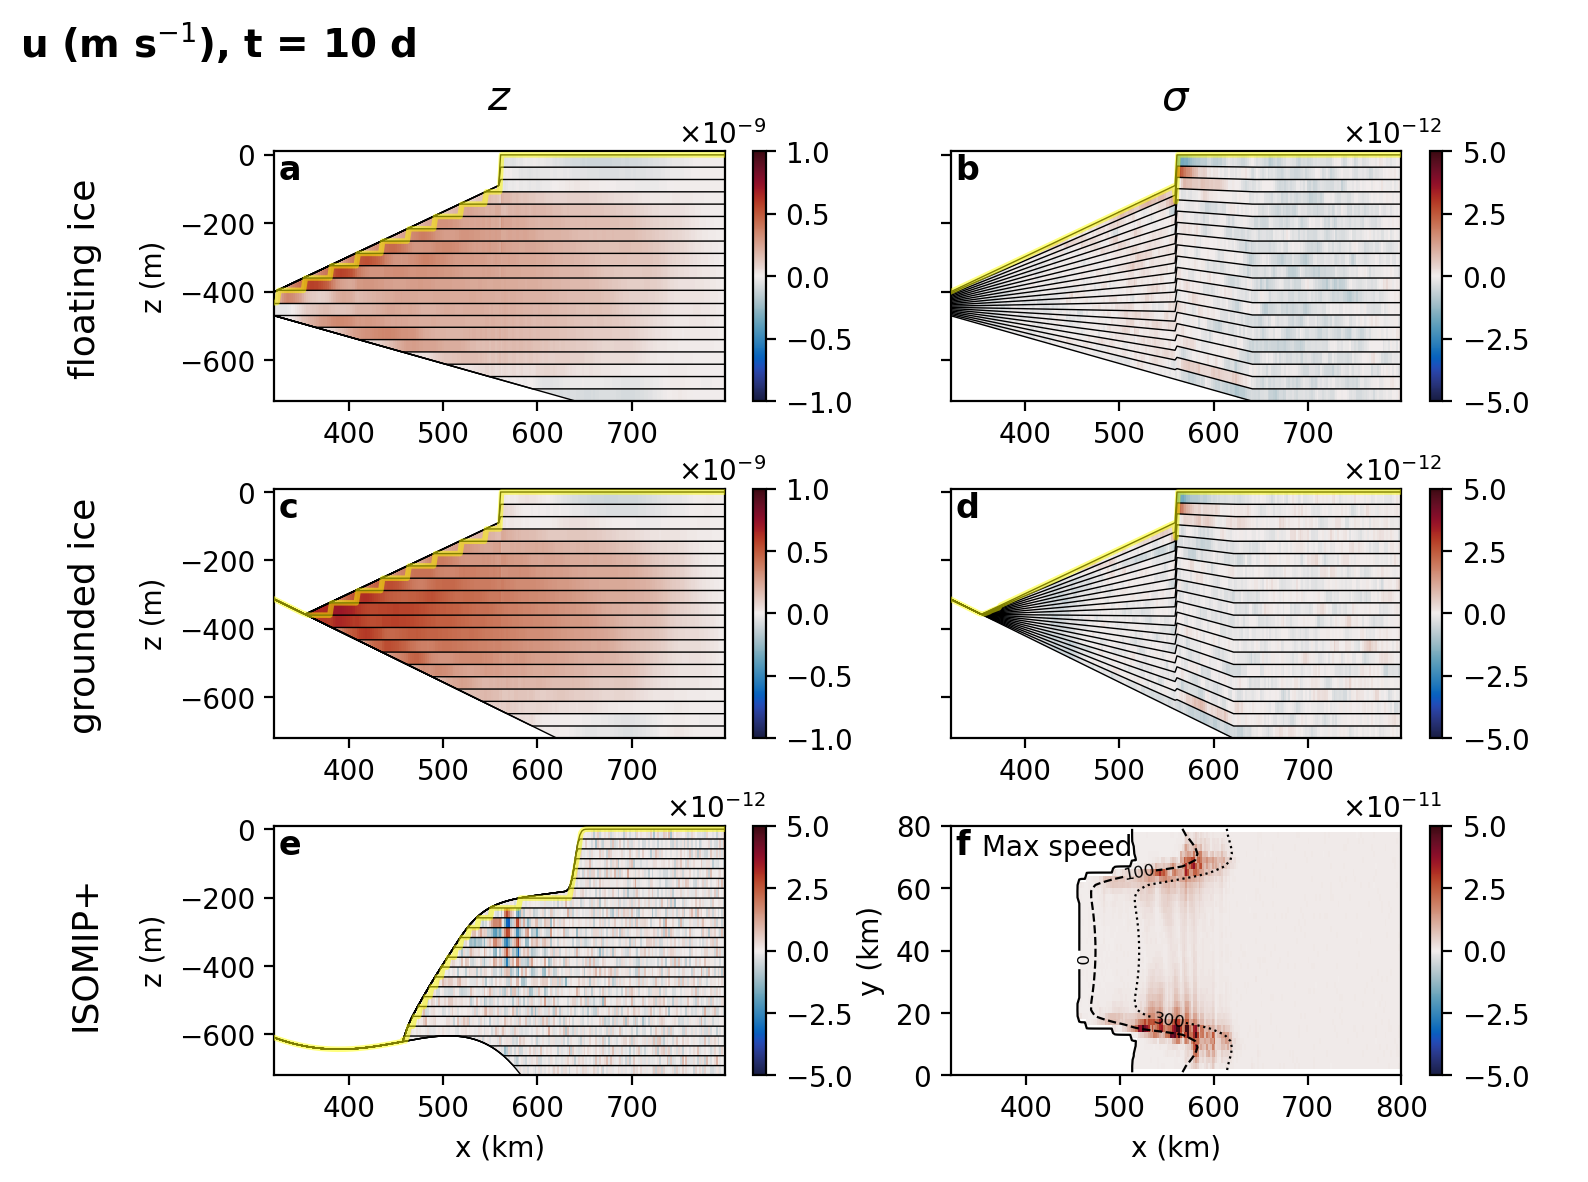

In [16]:
fig, axes = plt.subplots(ncols = 2, nrows = 3, figsize = (8,6),dpi = 200)
ax = np.ravel(axes)

for i in np.arange(4):

    label = ['iceshelf2-z','iceshelf2-sigma','iceshelf-z','iceshelf-sigma',][i]
    loc = [0,1,2,3][i]
    vmax = [1e-9,5e-12,
            1e-9,5e-12,1e-11][i]
    
    a = ax[loc]

    prog = open_files(label)
    x = 0
    ymax = 720

    plot_u(a,x,-1,prog.u,"uo",-vmax,vmax,cm.cm.balance,ymax, ymin = 10)

    a.set_title('')
    if loc < 4:
        a.set_xlabel('')
    if (loc ==0):
        a.set_ylabel('z (m)')
        a.text(120,-360,'floating ice',
               ha = 'center', va = 'center',rotation = 90, fontsize = 13)
    elif (loc==2):
        a.set_ylabel('z (m)')
        a.text(120,-360,'grounded ice',
               ha = 'center', va = 'center',rotation = 90, fontsize = 13)
        
    else:
        a.set_ylabel('')
        a.set_yticklabels('')
        
    if loc < 2:
        a.set_title(['$z$','$\sigma$'][loc], 
                    y = 1.1, fontsize = 15)
    a.text(0.01,0.99,['a','b','c','d','e','f','g','h','i','j'][i], fontsize = 12, transform=a.transAxes, fontweight='bold', va='top')

i = 4
vmax = 5e-12
a = ax[i]
prog = xr.open_dataset('/Users/claireyung/mom6/MOM6-examples/ocean_only/ISOMIP/seamount-icemount-PGtest-sep25/z-ISOMIP-quiet/prog__0001_002.nc')
ocean_geometry = xr.open_dataset('/Users/claireyung/mom6/MOM6-examples/ocean_only/ISOMIP/seamount-icemount-PGtest-sep25/z-ISOMIP-quiet/ocean_geometry.nc')
mom = xr.open_dataset('/Users/claireyung/mom6/MOM6-examples/ocean_only/ISOMIP/seamount-icemount-PGtest-sep25/z-ISOMIP-quiet/mom__0001_001.nc')
x = 20
ymax = 720

plot_u_ISOMIP(a,x,-1,prog.u,"uo",-vmax,vmax,cm.cm.balance,ymax)

a.set_title('')
a.set_xlabel('x (km)')
a.set_ylabel('z (m)')
a.text(120,-360,'ISOMIP+',
           ha = 'center', va = 'center',rotation = 90, fontsize = 13)
a.text(0.01,0.99,['a','b','c','d','e','f','g','h','i','j'][i], fontsize = 12, transform=a.transAxes, fontweight='bold', va='top')

i = 5
vmax = 5e-11
a = ax[i]
u_interp = 0.5*(prog.u.isel(Time = -1).values[:,:,:-1]+prog.u.isel(Time = -1).values[:,:,1:])
v_interp = 0.5*(prog.v.isel(Time = -1).values[:,:-1,:]+prog.v.isel(Time = -1).values[:,1:,:])

speed = (np.sqrt(u_interp**2+v_interp**2))
max_speed = np.max(speed,0)
max_speed = np.where(max_speed > 1e-15, max_speed, np.nan)

sum_h = prog.h.isel(Time = 0).sum('zl')
CS1 = a.contour(prog.xh.values, prog.yh.values,sum_h.values,levels = [0.5,100,300],colors = 'k', linewidths =0.8, linestyles = ['-','--','dotted'])
plt.clabel(CS1, CS1.levels, inline=True, fontsize=6,fmt ='%1.0f')
c = a.pcolormesh(prog.xq.values, prog.yq.values,max_speed,vmax = vmax, vmin = -vmax, cmap = cm.cm.balance)
cbar = plt.colorbar(c, ax = a, label = " ")
cbar.set_ticks([-5e-11,-2.5e-11,0,2.5e-11,5e-11])
cbar.formatter.set_powerlimits((0, 0))
cbar.formatter.set_useMathText(True)
cbar.ax.yaxis.set_offset_position('right')
cbar.update_ticks()
a.set_title('')
a.set_xlabel('x (km)')
a.set_ylabel('y (km)')
a.text(0.01,0.99,['a','b','c','d','e','f','g','h','i','j'][i], fontsize = 12, transform=a.transAxes, fontweight='bold', va='top')
a.text(0.07,0.97,'Max speed', fontsize = 10, transform=a.transAxes, va='top')

    
# #ax[0].set_axis_off()

fig.subplots_adjust(wspace = 0.2,hspace = 0.35)
fig.suptitle('u (m s$^{-1}$), t = 10 d', fontsize = 14, y = 0.99, x = 0.09,weight = 'bold')



plt.show()


# Manuscript figures end here. Below is extra code/explanation used for model setup/testing.

Written December 2024/January 2025

## USE HACKMODE TO try and fix sigma initialisation near GL

requires extra code, see below info

Hackmode is added to the executable to allow thickness to be initialised from file, and turn off modification of layers by ice shelf weight. This allows for perfect sigma initialisation buit requires first running the model to get some initial conditions of thickness, then rerunning it with a slightly different initialisation.

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import netCDF4 as nc
import cmocean as cm
from xgcm import Grid

def make_thickness_file(filename):
    
    ic = xr.open_dataset('/Users/claireyung/mom6/MOM6-examples/ocean_only/ISOMIP/seamount-icemount-PGtest-dec24/iceshelf-sigma/MOM_IC.nc')
    _, nz, ny, nx = ic.h.data.shape

    new_thick = nc.Dataset(filename, "w", format="NETCDF4")
    new_thick.createDimension("nz", nz)
    new_thick.createDimension("ny", ny)
    new_thick.createDimension("nx", nx)
    new_thick.createVariable("h","f8",("nz","ny","nx"))

    new_thick["h"][:,:,:] = ic.h.data
    new_thick.close()

In [6]:
make_thickness_file('/Users/claireyung/mom6/MOM6-examples/ocean_only/ISOMIP/seamount-icemount-PGtest-dec24/iceshelf-sigma/INPUT/thickness_simpleshelf2_pfile.nc')


params with this as before, but

```
!#override THICKNESS_CONFIG = "ISOMIP"
!#override TRIM_IC_FOR_P_SURF = True

! hackmode
#override THICKNESS_CONFIG = "thickness_file"
#override THICKNESS_FILE = "thickness_simpleshelf2_pfile.nc"  ! This is defined in make_thickness.ipynb
#override REMAP_AFTER_INITIALIZATION = False
#override HACK_MODE = True 
```

# Initialisation bug documentation

(Why I need to use a small hack for initialising sigma coordinates with a grounding line)

6-Jan-25

**Issue:** salinity/temperature initialisation not perfect in ALE sigma coordinates near the grounding line.

**Suspected reason:** remapping of initial conditions to desired ALE coordinate *AFTER* `trim_for_ice` module (which creates a consistent z-coord ice shelf).

**Reasoning:** 
- As shown in the figure below, initial conditions in `z` coordinates are perfect. They are not perfect in sigma coords near the GL, but if no GL they are perfect (bottom left). `sigma-shelf-zstar` coordinates are perfect as well.
- Since z coordinates have perfect initialisation, I think `trim_for_ice` module is fine. However, I am confused why remapping to ALE `sigma` coordinates has a problem whilst `sigma-shelf-zstar` coordinates do not.

**Temporary solution:**
- We can fix sigma coordinate initialisation using hack mode (as I did previously before other bugs with the ice shelf initialisation were fixed). Briefly, to use hack mode I first initialise the model, then save the thickness, then re-initialise the model without applying ice shelf pressure but using the thicknesses that know about the ice shelf. This means T and S get applied perfectly since it is just a function of depth.

Note initialisation parameters used in these test cases:

```
#override THICKNESS_CONFIG = "ISOMIP"
#override TRIM_IC_FOR_P_SURF = True
#override REMAP_BOUNDARY_EXTRAP = False
#override INIT_BOUNDARY_EXTRAP = True ! fixes previous bug with initialisation remapping to allow extrapolation in remapping
#override TRIMMING_USES_REMAPPING = True
#override TRIM_IC_Z_TOLERANCE = 1.e-14

#override REMAPPING_USE_OM4_SUBCELLS = False  ! fixes previous bug with initialisation remapping if ocean thickness changes
#override DIAG_REMAPPING_USE_OM4_SUBCELLS = False

```


My understanding of the ALE ice shelf initialisation:

1. Ocean gets initialised without ice shelf
2. Use `trim_for_ice` (called with `TRIM_IC_FOR_P_SURF = True`) which takes ice shelf pressure as input
3. `cut_off_column_top` gets called by trim_for_ice that truncates columns (making layers vanished). The output of this is a grid with the ice shelf boundary treated in a ALE z-coordinate fashion with vanishing layers at the surface. Since `TRIMMING_USES_REMAPPING = True`, T and S get remapped to what they should be. I think everything is correct given that the z coordinate initialisation is perfect.
4. Then, it needs to be regridded and remapped from this z-ice shelf coordinate to sigma coordinates. I think the problem occurs somewhere here. This can be done with regrid_accelerate in MOM_state_initialization or by the block controlled by `REMAP_AFTER_INITIALIZATION` in MOM.F90. Here, we want `INIT_BOUNDARY_EXTRAP  = True` (my PR here https://github.com/NOAA-GFDL/MOM6/pull/608)

Comparing the NK20 and NK40 cases, it looks like the salinity anomaly only occurs when the ocean in thinner than one z coordinate grid cell (40m and 20m respectively). How does remapping work when going from one or two nonvanished layers to a large number in the other coordinate?


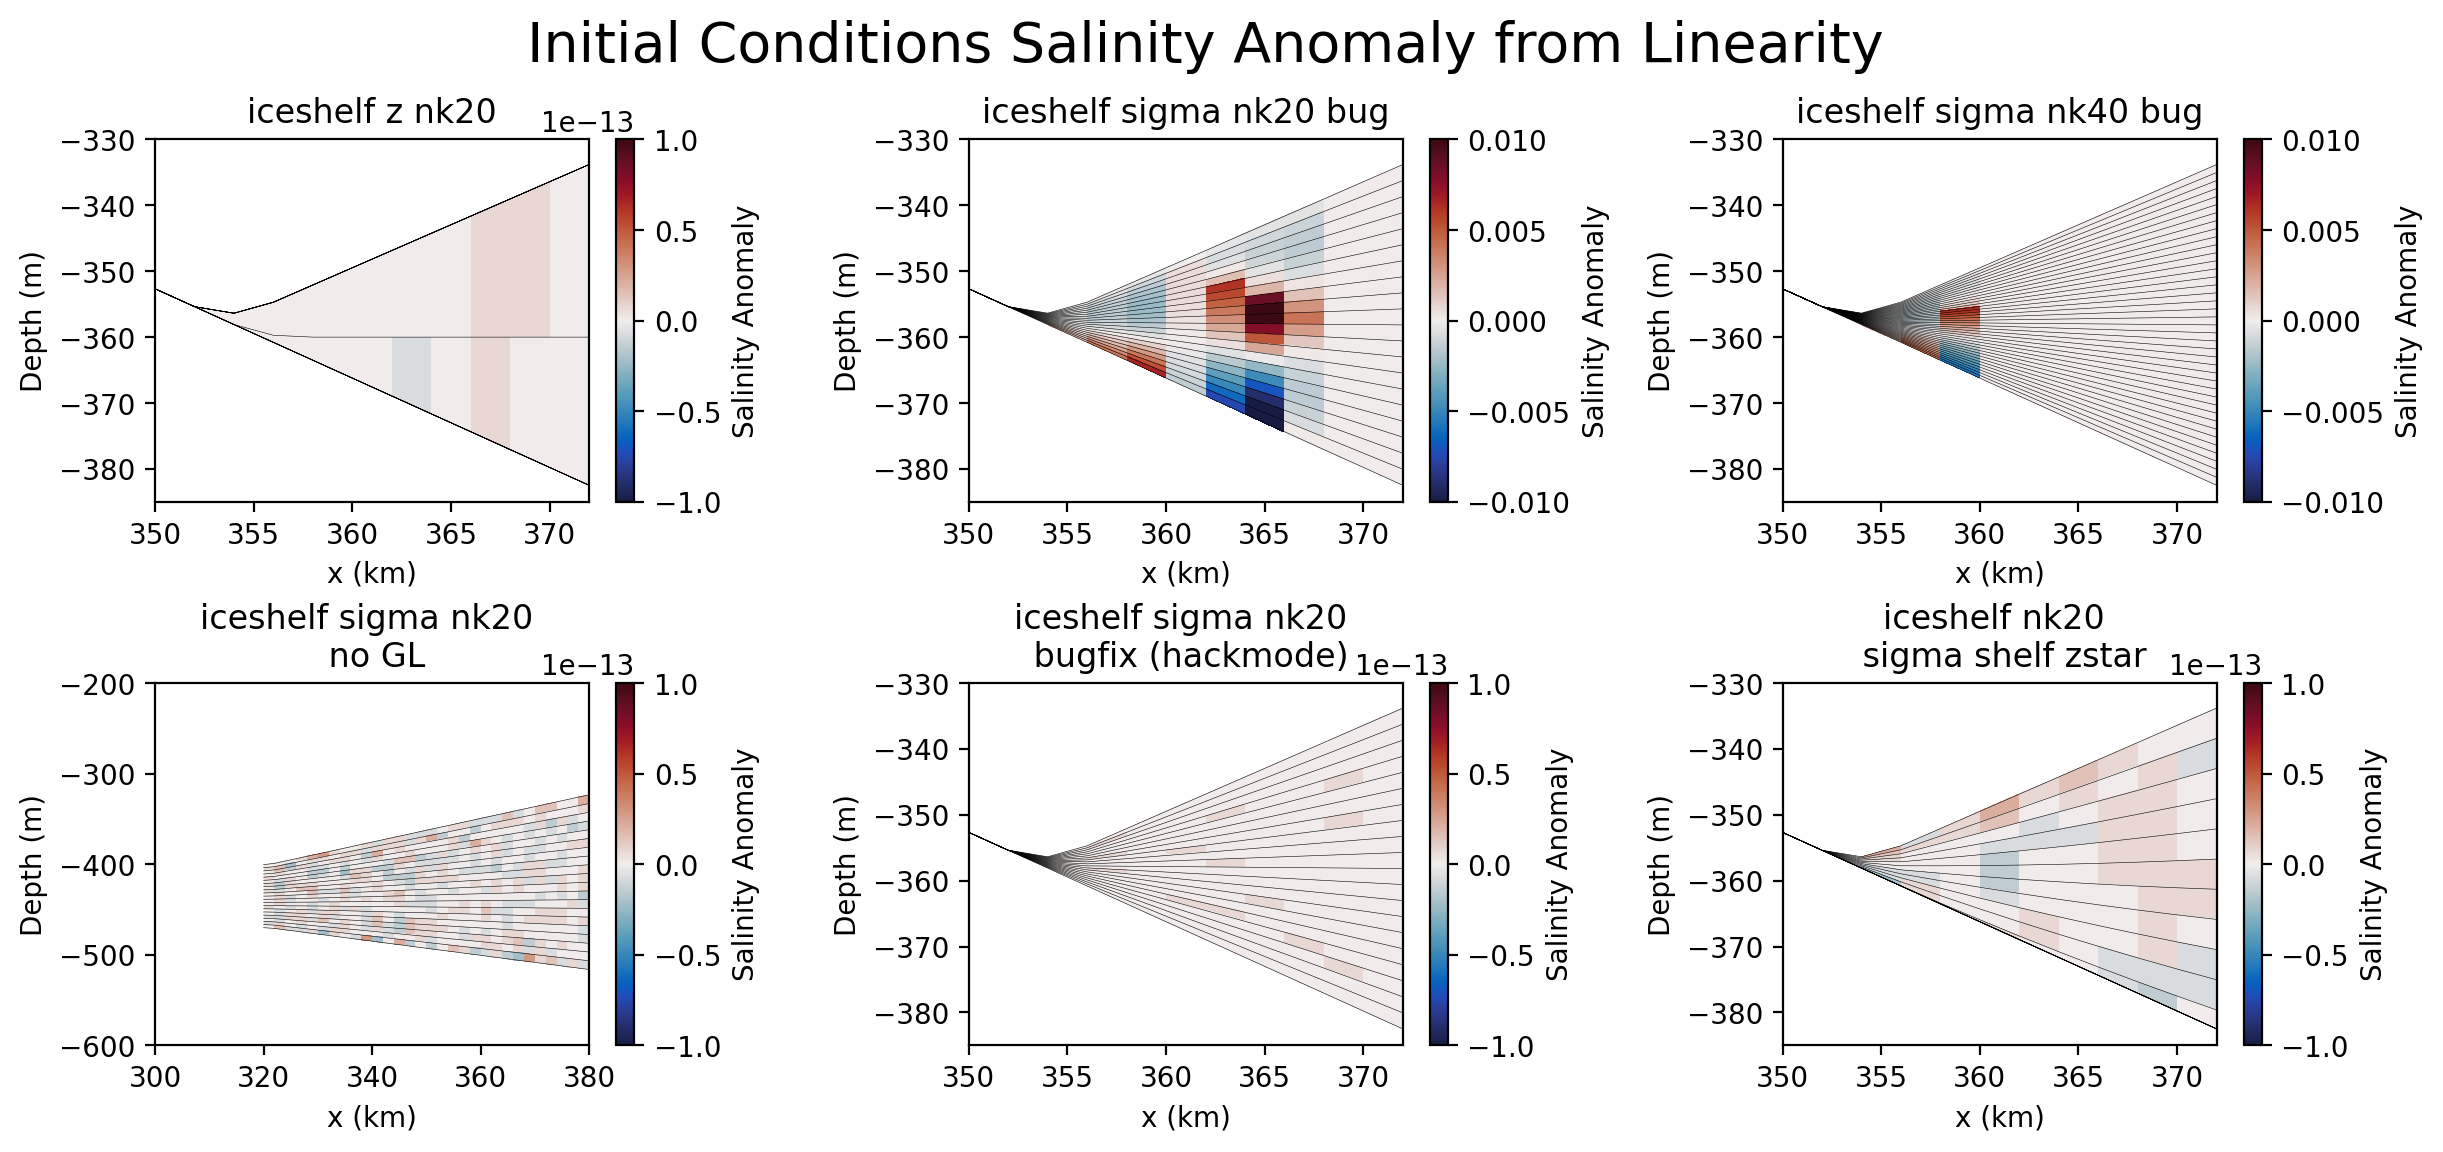

In [47]:
fig, axes = plt.subplots(nrows = 2, ncols = 3, figsize = (14,6),dpi = 200)
ax = axes.ravel()
for i in np.arange(6):
    label = ['iceshelf-z','iceshelf-sigma-bug','iceshelf-sigma-bug-nk40','iceshelf2-sigma','iceshelf-sigma',
             'iceshelf-sigmazstar'][i]
    nice_label = ['iceshelf z nk20','iceshelf sigma nk20 bug','iceshelf sigma nk40 bug',
                  'iceshelf sigma nk20 \n no GL','iceshelf sigma nk20 \n bugfix (hackmode)',
                 'iceshelf nk20 \n sigma shelf zstar'][i]

    IC = open_IC(label)
    time = 0
    x = 0
    ymax = 720
    vmax = [1e-13,1e-2,1e-2,1e-13,1e-13,1e-13][i]
    ideal_salt = xr.zeros_like(IC.Salt) + (IC.eta.isel(Interface = 0)-IC.h.cumsum('Layer')+IC.h/2)*(34.55-33.8)/(-ymax)+33.8 #\
    plot_t(ax[i],x,time,IC.Salt-ideal_salt,"Salinity Anomaly",-vmax, vmax,cm.cm.balance,ymax)
    ax[i].set_title(nice_label)
    ax[i].set_xlim(350,372)
    if label == 'iceshelf2-sigma':
        ax[i].set_ylim(-600,-200)
        ax[i].set_xlim(300,380)
#     elif label == 'iceshelf-sigmazstar':
#         ax[i].set_ylim(-360,-354)
#         ax[i].set_xlim(350,357)
#     elif label == 'iceshelf-sigma-bug-nk40':
#         ax[i].set_ylim(-370,-340)
#         ax[i].set_xlim(350,362)
    else:
        ax[i].set_ylim(-385,-330)
fig.suptitle('Initial Conditions Salinity Anomaly from Linearity',fontsize = 20)
fig.subplots_adjust(hspace = 0.5,wspace = 0.5)

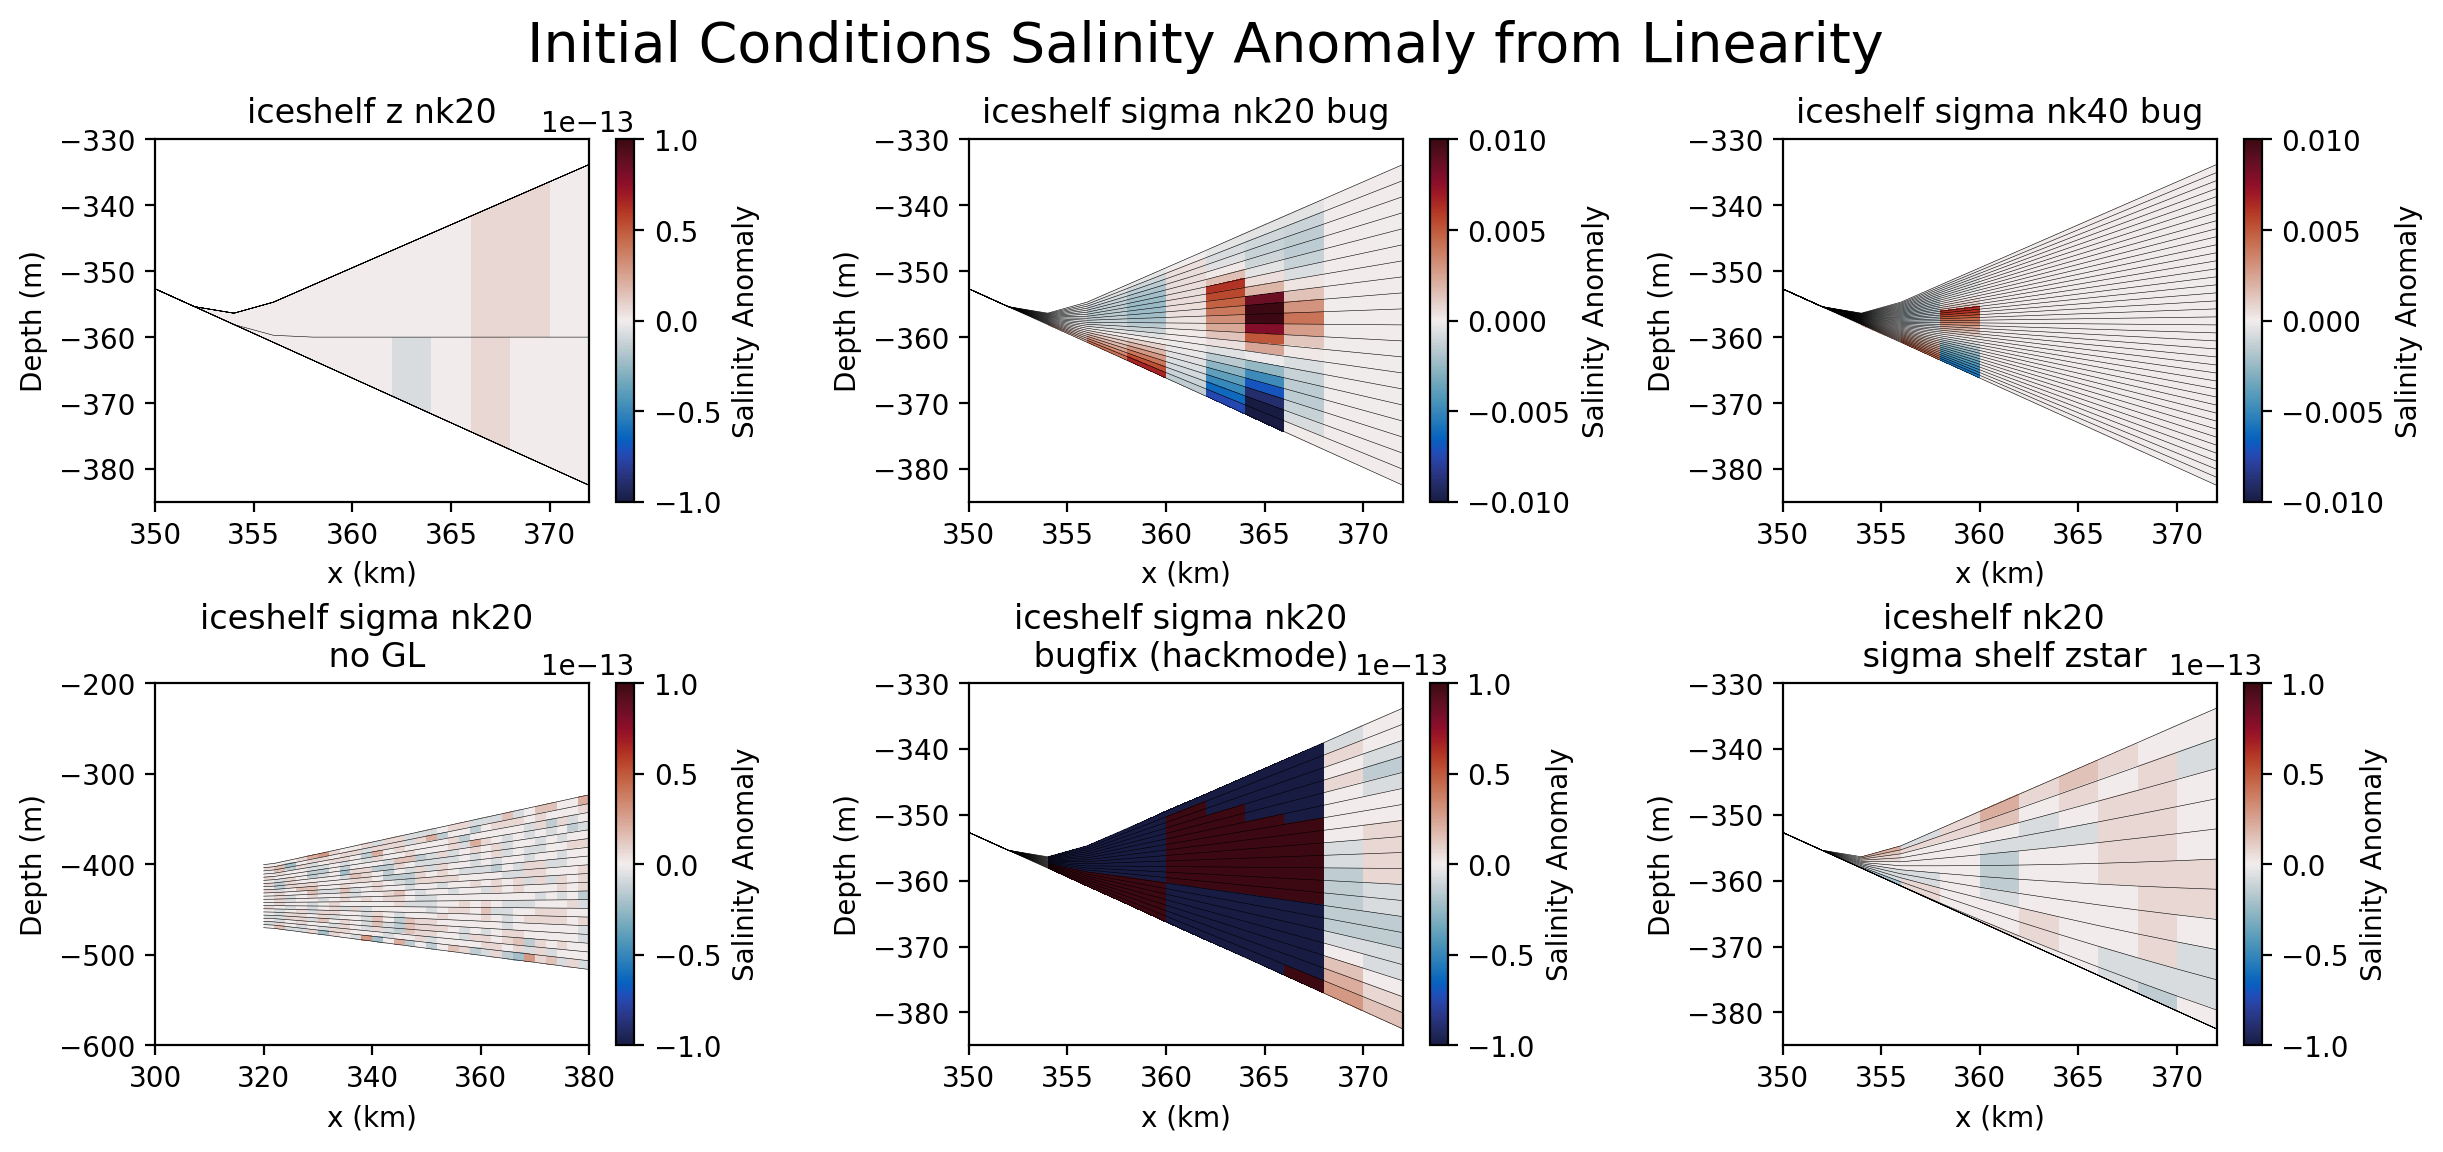

In [25]:
fig, axes = plt.subplots(nrows = 2, ncols = 3, figsize = (14,6),dpi = 200)
ax = axes.ravel()
for i in np.arange(6):
    label = ['iceshelf-z','iceshelf-sigma-bug','iceshelf-sigma-bug-nk40','iceshelf2-sigma','iceshelf-sigma',
             'iceshelf-sigmazstar'][i]
    nice_label = ['iceshelf z nk20','iceshelf sigma nk20 bug','iceshelf sigma nk40 bug',
                  'iceshelf sigma nk20 \n no GL','iceshelf sigma nk20 \n bugfix (hackmode)',
                 'iceshelf nk20 \n sigma shelf zstar'][i]

    IC = open_IC(label)
    time = 0
    x = 0
    ymax = 720
    vmax = [1e-13,1e-2,1e-2,1e-13,1e-13,1e-13][i]
    ideal_salt = xr.zeros_like(IC.Salt) + (IC.eta.isel(Interface = 0)-IC.h.cumsum('Layer')+IC.h/2)*(34.55-33.8)/(-ymax)+33.8 #\
    plot_t(ax[i],x,time,IC.Salt-ideal_salt,"Salinity Anomaly",-vmax, vmax,cm.cm.balance,ymax)
    ax[i].set_title(nice_label)
    ax[i].set_xlim(350,372)
    if label == 'iceshelf2-sigma':
        ax[i].set_ylim(-600,-200)
        ax[i].set_xlim(300,380)
#     elif label == 'iceshelf-sigmazstar':
#         ax[i].set_ylim(-360,-354)
#         ax[i].set_xlim(350,357)
#     elif label == 'iceshelf-sigma-bug-nk40':
#         ax[i].set_ylim(-370,-340)
#         ax[i].set_xlim(350,362)
    else:
        ax[i].set_ylim(-385,-330)
fig.suptitle('Initial Conditions Salinity Anomaly from Linearity',fontsize = 20)
fig.subplots_adjust(hspace = 0.5,wspace = 0.5)

### The velocities at t=1 timestep match the salinity anomalies.

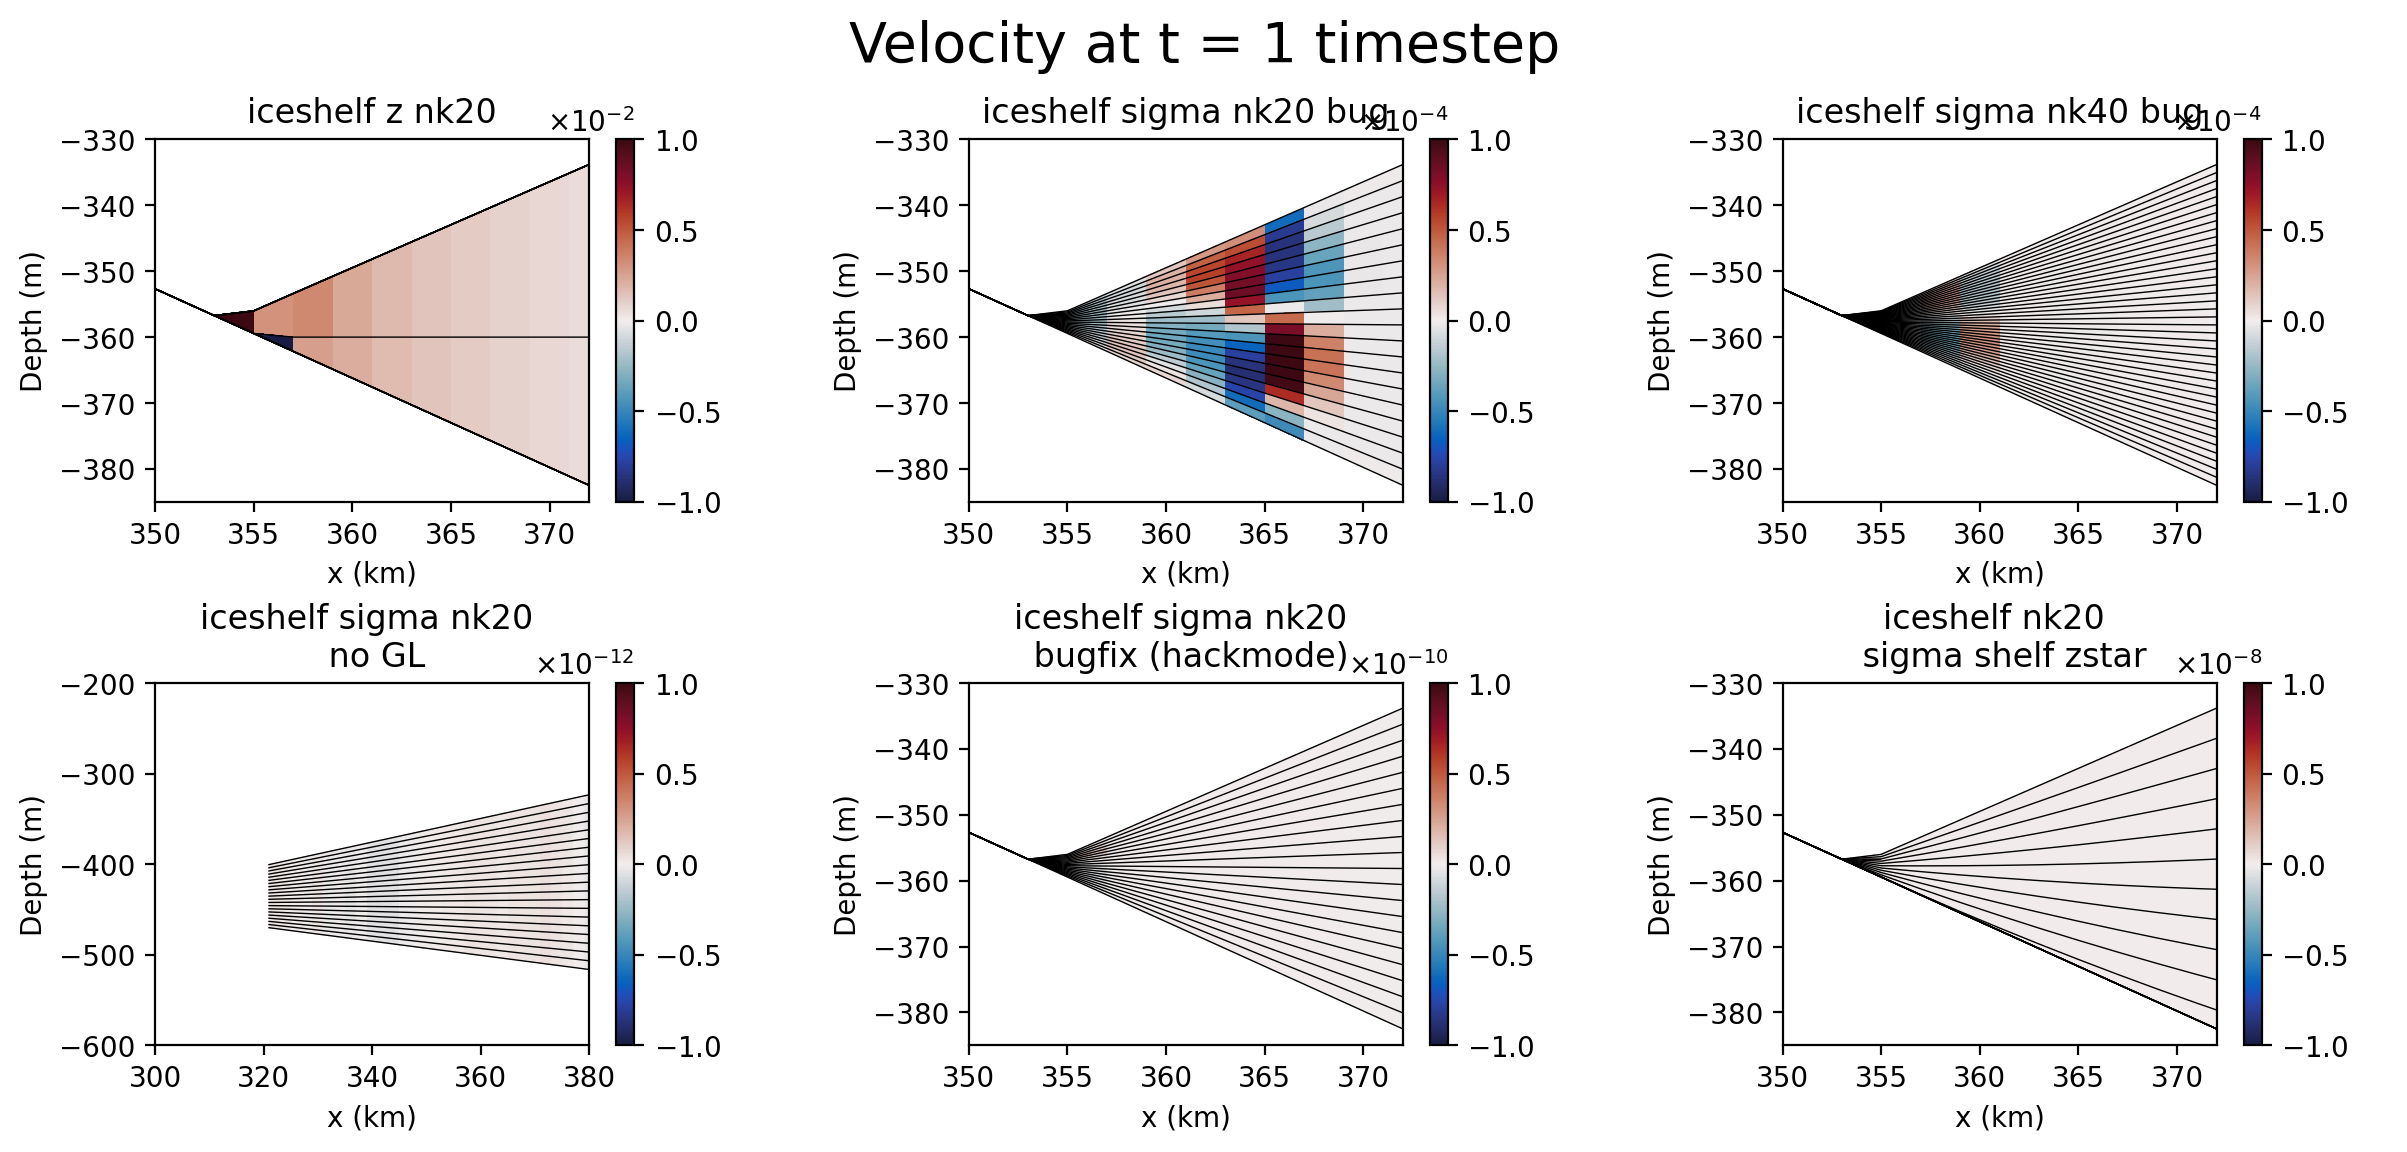

In [48]:
fig, axes = plt.subplots(nrows = 2, ncols = 3, figsize = (14,6),dpi = 200)
ax = axes.ravel()
for i in np.arange(6):
    label = ['iceshelf-z','iceshelf-sigma-bug','iceshelf-sigma-bug-nk40','iceshelf2-sigma','iceshelf-sigma',
             'iceshelf-sigmazstar'][i]
    nice_label = ['iceshelf z nk20','iceshelf sigma nk20 bug','iceshelf sigma nk40 bug',
                  'iceshelf sigma nk20 \n no GL','iceshelf sigma nk20 \n bugfix (hackmode)',
                 'iceshelf nk20 \n sigma shelf zstar'][i]

    prog = open_files(label)
    time = 0
    x = 0
    ymax = 720
    vmax = [1e-2,1e-4,1e-4,1e-12,1e-10,1e-8][i]
    plot_u(ax[i],x,time,prog.u,"uo",-vmax, vmax,cm.cm.balance,ymax)
    ax[i].set_title(nice_label)
    ax[i].set_xlim(350,372)
    if label == 'iceshelf2-sigma':
        ax[i].set_ylim(-600,-200)
        ax[i].set_xlim(300,380)
#     elif label == 'iceshelf-sigmazstar':
#         ax[i].set_ylim(-360,-354)
#         ax[i].set_xlim(350,357)
#     elif label == 'iceshelf-sigma-bug-nk40':
#         ax[i].set_ylim(-370,-340)
#         ax[i].set_xlim(350,362)
    else:
        ax[i].set_ylim(-385,-330)
fig.suptitle('Velocity at t = 1 timestep',fontsize = 20)
fig.subplots_adjust(hspace = 0.5,wspace = 0.5)

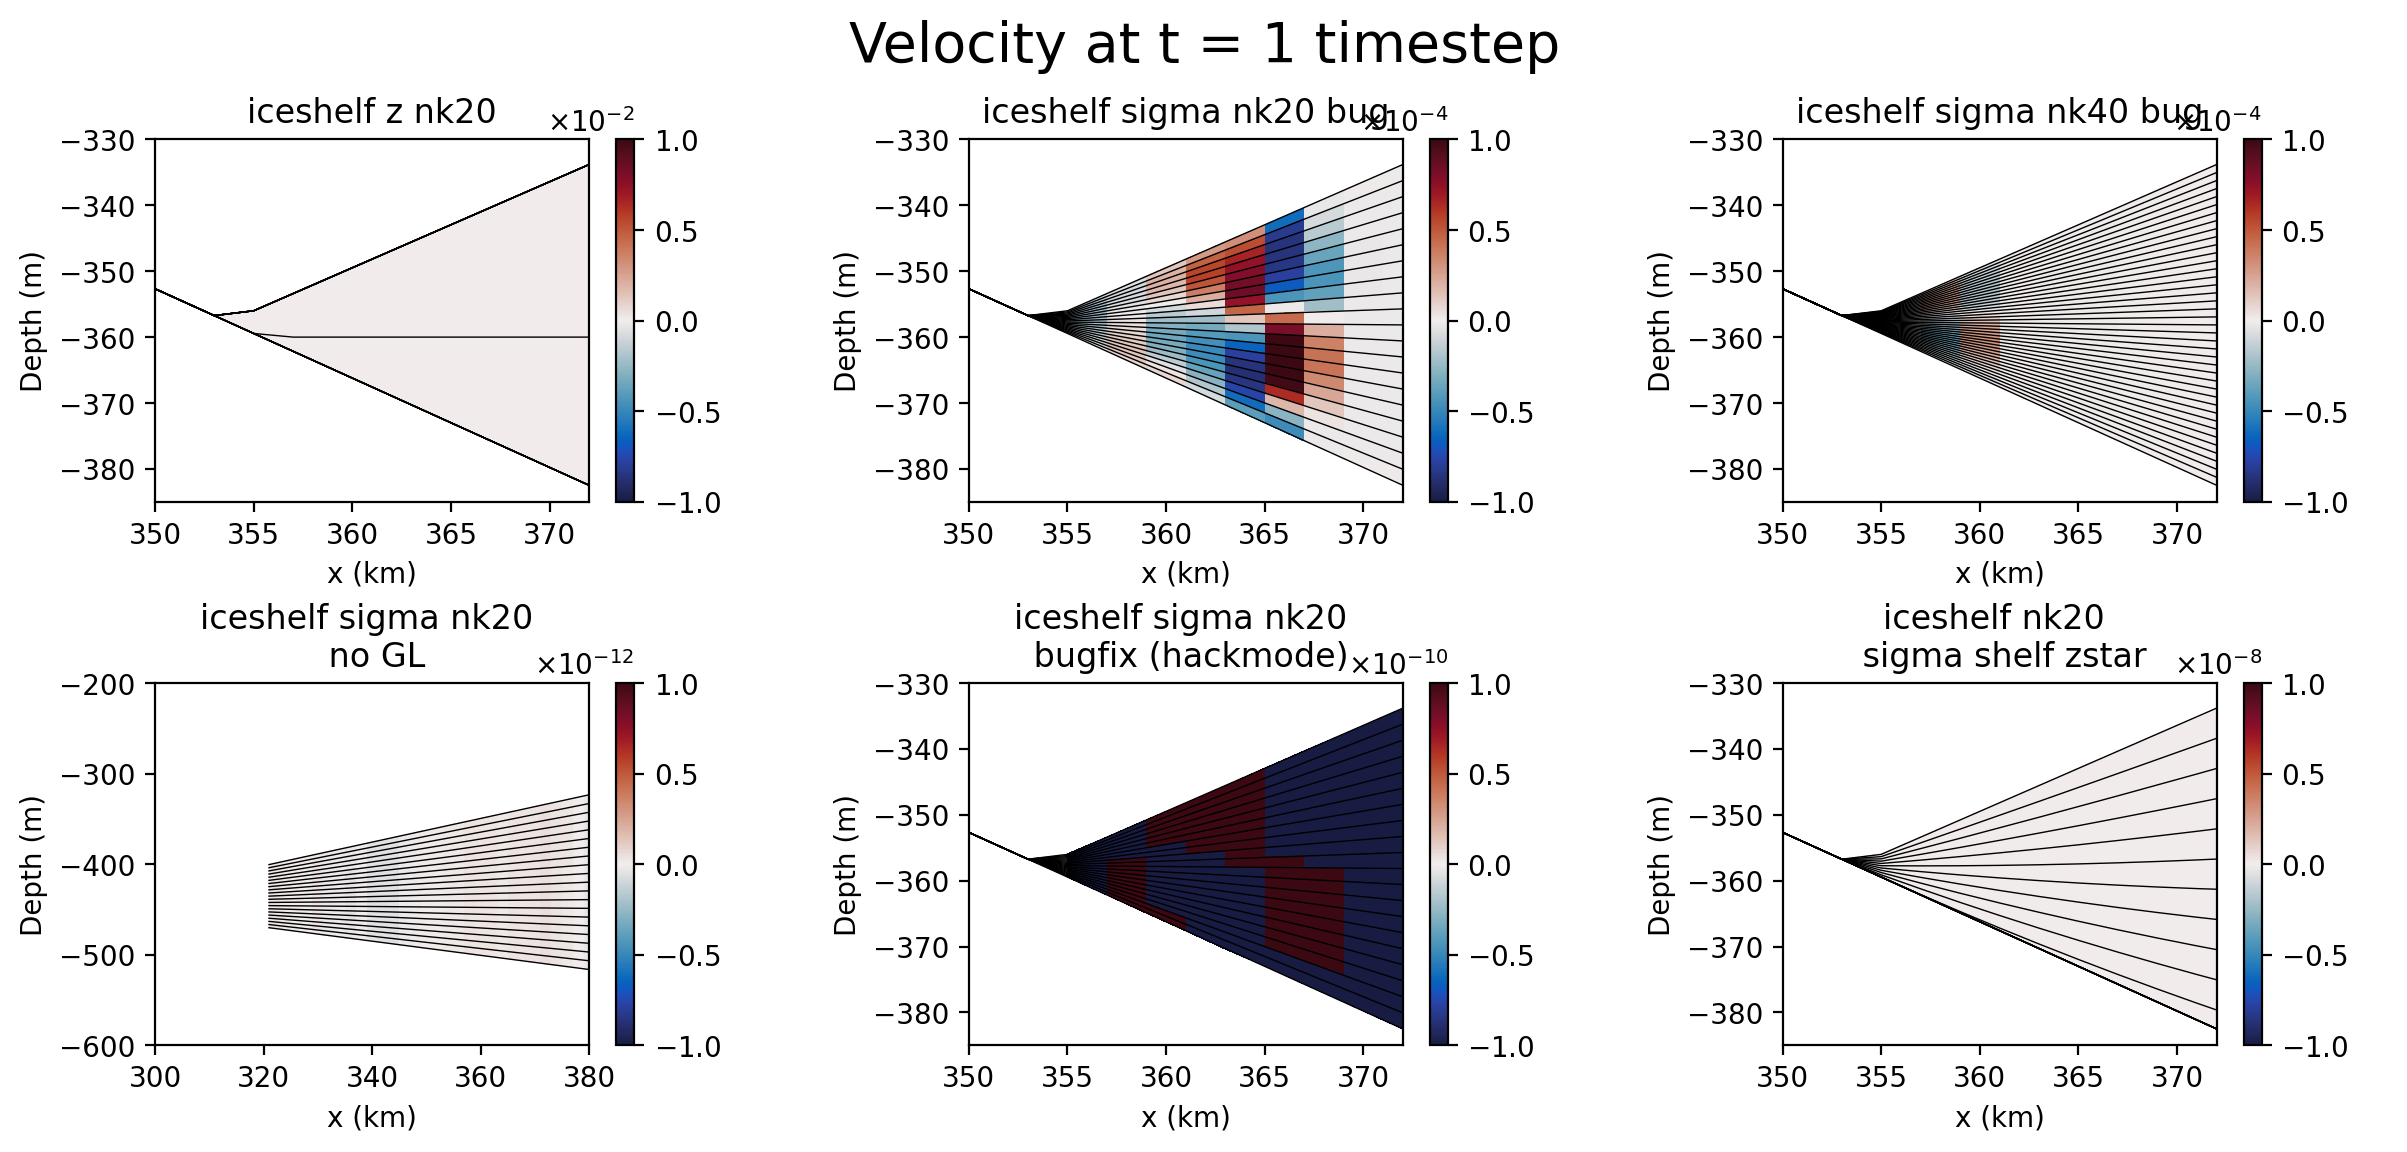

In [5]:
fig, axes = plt.subplots(nrows = 2, ncols = 3, figsize = (14,6),dpi = 200)
ax = axes.ravel()
for i in np.arange(6):
    label = ['iceshelf-z','iceshelf-sigma-bug','iceshelf-sigma-bug-nk40','iceshelf2-sigma','iceshelf-sigma',
             'iceshelf-sigmazstar'][i]
    nice_label = ['iceshelf z nk20','iceshelf sigma nk20 bug','iceshelf sigma nk40 bug',
                  'iceshelf sigma nk20 \n no GL','iceshelf sigma nk20 \n bugfix (hackmode)',
                 'iceshelf nk20 \n sigma shelf zstar'][i]

    prog = open_files(label)
    time = 0
    x = 0
    ymax = 720
    vmax = [1e-2,1e-4,1e-4,1e-12,1e-10,1e-8][i]
    plot_u(ax[i],x,time,prog.u,"uo",-vmax, vmax,cm.cm.balance,ymax)
    ax[i].set_title(nice_label)
    ax[i].set_xlim(350,372)
    if label == 'iceshelf2-sigma':
        ax[i].set_ylim(-600,-200)
        ax[i].set_xlim(300,380)
#     elif label == 'iceshelf-sigmazstar':
#         ax[i].set_ylim(-360,-354)
#         ax[i].set_xlim(350,357)
#     elif label == 'iceshelf-sigma-bug-nk40':
#         ax[i].set_ylim(-370,-340)
#         ax[i].set_xlim(350,362)
    else:
        ax[i].set_ylim(-385,-330)
fig.suptitle('Velocity at t = 1 timestep',fontsize = 20)
fig.subplots_adjust(hspace = 0.5,wspace = 0.5)